<a href="https://colab.research.google.com/github/GildasTaliah/RiskBasedOptimz/blob/main/PCAClustOptimzRets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PRINCIPAL COMPONENTS ANALYSIS, CLUSTERING AND OPTIMIZATION OF STOCK RETURNS**


# **Intro**

The idea of Principal Component Analysis (PCA) is to reduce the dimensionality of the dataset with a lrage number of variables while retaining as much variance as possible. Essentially, with PCA we obtain a different representation of the dataset with less dimension that can explain the majority of the entire original data set. In addition the new data set is decorrelated, that is less correlated than before.

Clustering is an unsupervised machnine learning technique (PCA too), wherein we group different parts of our dataset based on their similarity to other observations. Clustering algorithms examine the structure of datasets using some distance metrics inorder to extract commonnality.

In this analysis, we implement PCA to extract factors used in explaining the movements in market returns, we also present other use cases of PCA such as utilizing the data-driven derived risk factors to build trading strategies, and the construction of uncorrelated portfolios using principal components. Additionally, in the context of clustering, we aim to obtain clusters of stocks without labellings, and utilize a clustering technique in the framework of Hierarchical Clustering to build portfolios that outperform out-of-sample.





# **PCA**


PCA by far is the most popular dimensionality reduction technique, first it identifeis the hyperplane that lies closest to the data and then it projects the data unto it.  PCA identifies the axis that accounts for the largest amount of variance in the data. This procedure engineers the translation of a set of correlated data with a high-dimension into a set of uncorrelated components with lower dimension. [More on PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)

How can we obtain principal componets ?

Through a matrix factorization techniqie called **Singular Value decomposition** SVD, that can decompose a dataset or or a given matrix $X$ into the matrix multiplication of three matrices $U \Sigma V^T$, where $V$ is the principal component we are looking for.

$\begin{pmatrix} | & | & | & \cdots & | \\ V_{1} & V_{2} & V_{3} & \cdots & V_{n} \\ | & | & | & \cdots & |  \end{pmatrix}$


Principal component matrix.
The first PC captures the direction of the maximum variance in the data.

In the following, we want to obtain factors that explains the movements in market returns. For this analysis we utilize the DAX 40 and DIJA 30 constituents. We proceed to dowload this stocks as follows.

In [1]:
# Global imports
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
# URL of the Wikipedia page containing the list of DAX 40 companies
url = 'https://en.wikipedia.org/wiki/DAX'

# Read the fourth table on HTML page
dax_table = pd.read_html(url, header=0)[4]

# Extract Ticker column and make list of tickers
dax_tickers = dax_table.Ticker.to_list()

# Display the first few tickers
print(dax_tickers[:5])

['ADS.DE', 'AIR.PA', 'ALV.DE', 'BAS.DE', 'BAYN.DE']


In [3]:
# URL of the Wikipedia page containing the list of DJIA 30 companies
url = 'https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average'

# Read the first table on the HTML page
djia_table = pd.read_html(url, header=0)[2]

# Extract Symbol column and make list of tcikers
djia_tickers = djia_table.Symbol.to_list()

# Display the first few tickers
print(djia_tickers[:5])

['MMM', 'AXP', 'AMGN', 'AMZN', 'AAPL']


In [4]:
Tickers = {'DAX-40': dax_tickers, 'DJIA-30':  djia_tickers}

In [5]:
# Function to read data from yahoo
def read_data(tickers: list, start: str, end: str, freq: str) -> pd.DataFrame:
   """
   Read data from yahoo finance, takes in list of tickers and returns df with Adj Close prices
   """
   return (yf.download(tickers, start=start, end=end, interval=freq)['Adj Close'])

In [6]:
# Download data in-sample data
start = '2020-01-01'
end = '2023-06-30'
freq = '1wk'
Data = ({key: read_data(ticker, start, end, freq) for key, ticker in
           Tickers.items()})

[*********************100%***********************]  40 of 40 completed
[*********************100%***********************]  30 of 30 completed


In [7]:
#help(yf.download)

In [8]:
# Check missing values
{key: data.isnull().values.any() for key , data in Data.items()}

{'DAX-40': True, 'DJIA-30': False}

In [9]:
miss_data = [Data['DAX-40'][col].isna().sum() for col in Data['DAX-40'].columns]
np.array(miss_data), Data['DAX-40'].shape

(array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 101,  39,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0, 143,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0]),
 (183, 40))

In [10]:
miss_data = [Data['DJIA-30'][col].isna().sum() for col in Data['DJIA-30'].columns]
np.array(miss_data), Data['DJIA-30'].shape

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]),
 (183, 30))

The ideal thing to do here is to drop columns with significant amount of missing values, and then apply forward fill, backward fill missing values for those with less such as 10 NAs. we We'don not have missing values for DJIA therefore the **pd.dropna** method would not have any effect. However, the DAX has **na** value also greater than 5, thus we will just drop the missing values columns altogether.

In [11]:
# Clean data, drop columns with NA values
Data_c = {key: Data[key].dropna(axis= 1) for key in Data.keys()}

In [12]:
# Check missing values once more
{key: data.isnull().values.any() for key , data in Data_c.items()}

{'DAX-40': False, 'DJIA-30': False}

In [13]:
# Recheck to see how fucntion ran out
miss_data = [Data_c['DAX-40'][col].isna().sum() for col in Data_c['DAX-40'].columns]
np.array(miss_data), Data_c['DAX-40'].shape

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 (183, 37))

In [14]:
# Compute returns and drop rows with NA values
Returns = {key: data.pct_change().dropna() for key, data in Data_c.items()}

In [15]:
# Include Market Returns, the average of all constituents
Returns_mrk = {key: returns.assign(MrkRet = returns.mean(axis = 1)) for key, returns in Returns.items()}

In [16]:
Returns_mrk['DAX-40'].head()

Ticker,1COV.DE,ADS.DE,AIR.PA,ALV.DE,BAS.DE,BAYN.DE,BEI.DE,BMW.DE,BNR.DE,CBK.DE,...,RWE.DE,SAP.DE,SHL.DE,SIE.DE,SRT3.DE,SY1.DE,VNA.DE,VOW3.DE,ZAL.DE,MrkRet
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-06 00:00:00+00:00,-0.030072,0.058572,0.002835,0.005478,-0.021406,0.038303,0.019404,0.017048,0.032896,-0.006390,...,0.090164,0.027395,0.025870,-0.003094,0.046875,-0.038651,0.006996,0.050272,0.005081,0.021335
2020-01-13 00:00:00+00:00,0.006398,0.008413,0.017557,-0.002724,-0.019900,-0.001460,-0.016713,-0.047070,-0.016126,-0.081523,...,0.058100,0.017776,-0.012609,0.009483,0.075622,0.008441,0.024520,-0.022424,0.035385,0.000816
2020-01-20 00:00:00+00:00,-0.027873,0.004332,0.016230,0.005919,-0.012864,0.000000,0.005666,-0.023220,-0.001639,-0.027252,...,0.031008,0.007463,0.047016,0.007003,0.012026,0.023789,0.021539,-0.021173,-0.023137,0.002252
2020-01-27 00:00:00+00:00,-0.040493,-0.086901,-0.041439,-0.023082,-0.041137,-0.029236,-0.038498,-0.073044,-0.037964,0.011673,...,-0.018170,-0.071552,-0.057989,-0.053256,-0.037477,-0.000215,0.006248,-0.085286,-0.056280,-0.038763
2020-02-03 00:00:00+00:00,0.000000,0.011547,0.026569,0.054899,0.022433,0.062697,0.016602,0.005440,0.055034,0.117885,...,0.037970,0.053132,-0.040254,-0.029917,0.064577,0.045836,0.017074,0.024880,0.031545,0.037676


In [17]:
Returns_mrk['DJIA-30'].head()

Ticker,AAPL,AMGN,AMZN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,NKE,NVDA,PG,SHW,TRV,UNH,V,VZ,WMT,MrkRet
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-08 00:00:00+00:00,0.047890,0.008234,-0.019624,0.047293,-0.014617,0.002049,0.034773,0.013715,-0.023182,-0.003432,...,0.011201,0.030634,0.022133,0.025180,0.011024,-0.005349,0.039006,-0.009396,-0.003261,0.015195
2020-01-15 00:00:00+00:00,0.012441,-0.010000,0.012068,0.013432,-0.057108,-0.005658,0.017296,0.021134,-0.025709,-0.011295,...,0.016129,0.002669,0.011228,0.032360,0.031175,0.042638,0.057332,0.032313,-0.005078,0.010697
2020-01-22 00:00:00+00:00,0.003538,-0.053704,-0.020481,0.014709,0.010180,-0.055885,-0.013062,-0.021106,-0.019327,-0.036152,...,-0.039874,0.000121,-0.000476,-0.003389,-0.046271,-0.048780,-0.021419,0.006300,0.008738,-0.017324
2020-01-29 00:00:00+00:00,0.003652,-0.013476,0.105987,-0.004530,0.004359,-0.023622,0.030025,-0.003140,-0.038427,0.045964,...,0.009660,-0.003387,0.002988,-0.006903,-0.013468,-0.017595,0.003500,-0.039703,-0.011407,0.007838
2020-02-05 00:00:00+00:00,0.002383,0.032235,0.049340,0.005916,0.083286,0.020074,0.004088,0.031709,0.040805,-0.025703,...,-0.013415,0.084004,-0.011937,-0.016917,0.036205,0.035429,0.001867,0.006862,0.001128,0.016240


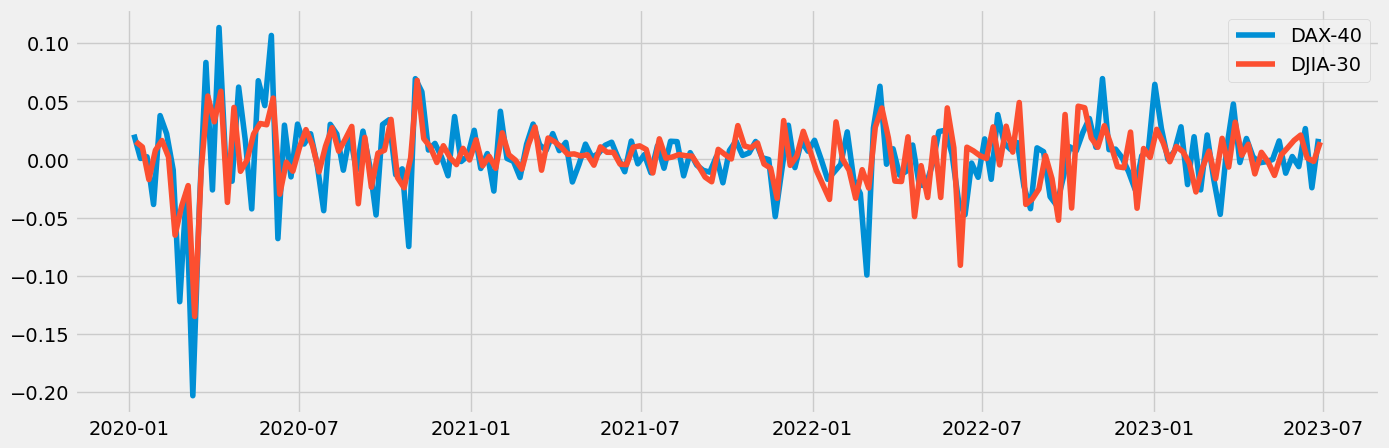

In [18]:
# Visualize Market Returns

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.figure(figsize=(15, 5))
plt.plot(Returns_mrk['DAX-40'].MrkRet, label = 'DAX-40')
plt.plot(Returns_mrk['DJIA-30'].MrkRet, label = 'DJIA-30')
plt.legend()
plt.show()

We observe that the returns depict characteristics of changing mean and variances across time, making it non-stationary. Non-sataionarity is further confirm  with the existence of visible periods of spikes and **volatility clustering**, which is quite noticeable during the second quarter of 2020 - the height of the covid era.

> Volatility clustering is a period characterised by a period of very low returns followed by a period of very low returns.

In [20]:
# Compute covariance
Cov = {key: returns.cov() for key, returns in Returns.items()}

In [21]:
from sklearn.decomposition import PCA

## Applying PCA on the covariance
# DE: German DAX Stocks
pca_de = PCA()
pca_de.fit(Cov['DAX-40'])

# US: United States DJIA Stocks
pca_us = PCA()
pca_us.fit(Cov['DJIA-30'])

PCA()

In [22]:
# Compute PC needed to explain 95% variation

def plotPCA(pca: PCA,  var_th: float = 0.95, plot: bool = True) -> None:

  ''' Takes in fitted pca model, obtains minimum number of pc to explain the
  variance of the data, and plots the results.
  '''

  ## Visualizing Variance explained against number of principal components

  var_threshold = var_th
  var_explained = np.cumsum(pca.explained_variance_ratio_)
  num_comp = np.where(np.logical_not(var_explained < var_threshold))[0][0] + 1

  if plot:
      print('%d principal components explains %.2f%% of variance' %(num_comp, 100* var_threshold))

      # PCA percent variance explained
      bar_width = 0.9
      n_asset = len(pca.explained_variance_ratio_)
      x_indx = np.arange(n_asset)
      fig, ax = plt.subplots(figsize=(10, 5))


      rects = ax.bar(x_indx, pca.explained_variance_ratio_[:n_asset], bar_width)
      ax.set_xticks(x_indx + bar_width / 2)
      ax.set_xticklabels(list(range(n_asset)), rotation=45)
      ax.set_title('Percent variance explained')
      ax.set_ylabel('Explained Variance')
      ax.set_xlabel('Principal Components')
      plt.show()

7 principal components explains 95.00% of variance


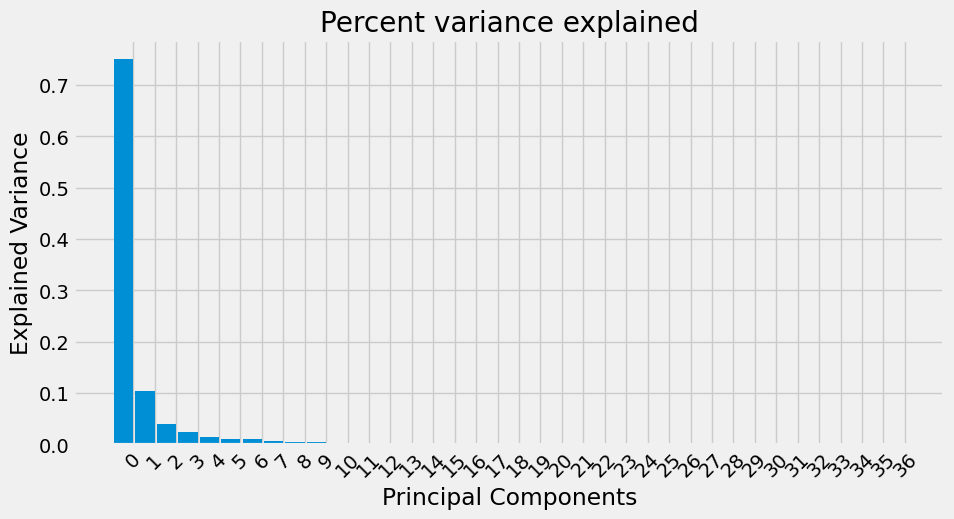

In [23]:
# Plot for DAX
plotPCA(pca= pca_de)

7 principal components explains 95.00% of variance


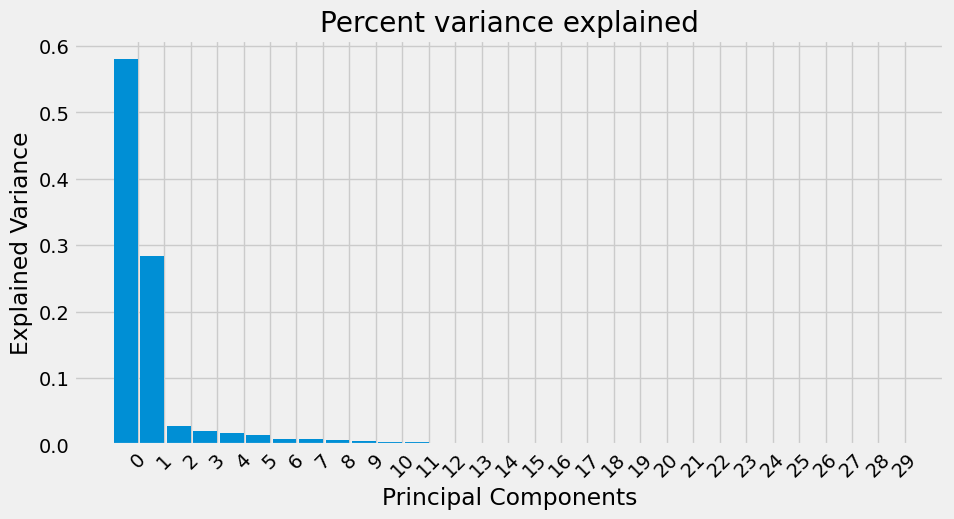

In [24]:
# Plot for DJIA
plotPCA(pca= pca_us)

As observed, DAX 40 index requires first 7 principal components to explain atleast 95% of the variation in the returns data. Coincidentally, we need same amount of  principal components to explain atleast 95% percent of the variation in DJIA 30 returns data.

$$\quad$$

# **Financial Feature (Factor) Engineering**

Feature engineering in Machine Learning is a key ingredient for successful predictions in predictive analytics, which is no difference with algorithmic trading. Factors are a transformation of market, fundamentals, statistical, structured, unstructured, and alternative data that contain predictive signals. They are designed to capture risk that drive asset's returns. In this section of the analysis our focus will be to obtain statistical features (factors) with PCA. In a future series we would implement the idea in a trdaing environment.  

There are numerous ways to extract PCA risk factors (risk premia) that can be used  to build a (contemporaneous) regression model to explain asset's returns or be used in a predictive model to predict next day return percentage or market movements.

Let us consider the number of explanatory variables in the universe to be **K**, with PCA we can obtain a smaller number of explanatory variables (factors) **K'**  such that: the level of explanatory power remain as high as possible. Moreover the resulting factors are a linear combination of the original explanatory variables, and are (the factors) also are orthogonal (uncorrelated).  

Below we present two ways we'll obtain financial features (factors) through PCA:
- 1. First we utilize the covariance matrix of the underlying stock returns, we proceed to obtain N principal components from it, and project the returns data unto a hyperplane define by this these components in order to obtain our statistical factors that can now be used as features in our model.
- 2. Secondly we obtain N principal components directly from the underlying returns data and project (transform) the returns data unto a hyperplane defined by the obtained N-principal components and result to N-factors needed for our modelling.   







In [25]:
#### PCA factors from covariance matrix
####

''' The PCs are the rows thefore we transpose the matrix
'''
## Principal componennts  PC
pcs_covde = pd.DataFrame(pca_de.components_, columns = Returns['DAX-40'].columns).T
pcs_covus = pd.DataFrame(pca_us.components_, columns = Returns['DJIA-30'].columns).T
pcs_covde.columns = ['PC' + str(1+i) for i in range(len(Returns['DAX-40'].columns))]
pcs_covus.columns = ['PC' + str(1 +i) for i in range( len(Returns['DJIA-30'].columns))]
pcs_covde.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37
Ticker,,,,,,,,,,,,,,,,,,,,,
1COV.DE,0.160264,0.119791,-0.037015,-0.034886,-0.328523,0.041804,-0.412621,-0.026476,-0.172847,-0.096781,...,0.059078,-0.142554,0.017899,0.029820,-0.150486,-0.020774,-0.048588,-0.008862,0.050865,0.280650
ADS.DE,0.141712,0.250014,0.026118,-0.086480,-0.151581,-0.244831,-0.216169,-0.328997,0.141437,0.555005,...,0.093482,0.018580,-0.006275,0.012724,-0.040191,-0.078938,-0.010111,0.052667,0.014955,-0.106219
AIR.PA,0.305527,-0.156789,0.162671,-0.155315,0.163674,-0.492903,-0.174477,0.100390,-0.151567,-0.162825,...,-0.196696,-0.085971,-0.254496,0.227335,-0.059949,-0.163446,-0.112305,-0.072334,0.031649,-0.053036
ALV.DE,0.179537,-0.072948,0.000389,-0.042156,-0.088615,-0.059255,0.164207,-0.042962,0.010479,-0.083597,...,0.029282,-0.136585,-0.033819,0.118551,0.219169,0.202940,-0.103679,0.735728,-0.220734,0.174740
BAS.DE,0.190768,0.056314,-0.063857,0.075626,-0.220193,-0.085493,-0.121810,-0.079259,-0.005046,0.041801,...,-0.020345,0.101096,-0.177116,-0.247750,0.075613,0.335616,0.201601,0.082367,0.036501,-0.175011


In [26]:
# Create/Obtain column names and index
cols_de = ['Fac' + str(1+i) for i in range(len(Returns['DAX-40'].columns))]
cols_us =['Fac' + str(1 +i) for i in range( len(Returns['DJIA-30'].columns))]
index_de = Returns['DAX-40'].index
index_us = Returns['DJIA-30'].index

In [27]:
## Factors (Financial Features)
fact_pca_covde = Returns['DAX-40'] @ pcs_covde
fact_pca_covus = Returns['DJIA-30'] @ pcs_covus

fact_pca_covde.columns = cols_de
fact_pca_covus.columns = cols_us

fact_pca_covus.head()

,Fac1,Fac2,Fac3,Fac4,Fac5,Fac6,Fac7,Fac8,Fac9,Fac10,...,Fac21,Fac22,Fac23,Fac24,Fac25,Fac26,Fac27,Fac28,Fac29,Fac30
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-08 00:00:00+00:00,0.070378,0.006117,-0.015823,-0.009877,0.057550,0.012176,-0.016056,0.033229,-0.063669,-0.013757,...,-0.001344,0.008582,-0.001265,0.018365,-0.005105,0.014062,0.017108,-0.001914,0.012216,0.011686
2020-01-15 00:00:00+00:00,0.022923,-0.026714,0.001471,-0.014370,0.083100,0.013203,-0.011128,0.049588,0.002392,-0.001262,...,0.033166,-0.003235,-0.020783,-0.019194,-0.008529,0.013880,0.029737,0.012272,0.017070,0.026729
2020-01-22 00:00:00+00:00,-0.043369,-0.052788,0.027600,-0.011022,-0.028731,0.007070,-0.030310,-0.029731,-0.023353,-0.031696,...,-0.006751,-0.002370,0.018251,0.004776,-0.004008,0.028481,-0.009351,0.019883,-0.010977,-0.026587
2020-01-29 00:00:00+00:00,0.070603,-0.055646,0.038344,-0.080559,0.002734,0.004418,-0.012858,-0.011816,0.036340,-0.044099,...,-0.012842,0.033012,0.018528,-0.013255,0.005620,0.032421,-0.015251,-0.001352,-0.000691,0.008277
2020-02-05 00:00:00+00:00,0.106414,0.033971,0.034529,0.041675,-0.058566,-0.042797,-0.046620,0.021568,0.024439,-0.005238,...,0.014717,0.006954,-0.020142,-0.024906,0.016939,-0.001029,-0.006875,-0.004033,0.016305,0.017972


In [28]:
#### PCA factors from asset returns directly
####

## Instantiate model
pca = PCA()
# Performs PCA on smaller number of predictors
pca.fit(Returns['DAX-40'] )
# Rotation, so PCs are the columns
P = pd.DataFrame(pca.components_, columns= Returns['DAX-40'].columns ).T
# Tidying up columns names
P.columns = ['P' + str(col + 1) for col in P.columns]
# Now project the returns unto the hyperplane defined by the pca

fact_pret_de = pd.DataFrame( np.matmul( Returns['DAX-40'].values ,P))
fact_pret_de.index = Returns['DAX-40'].index
fact_pret_de

## Shorter approach: fit pca model and transform (project)
## Factors (Financial Features)
# DAX DE
fact_pca_retde = pd.DataFrame( PCA().fit_transform(Returns['DAX-40']), columns = cols_de, index= index_de )

# DJIA US
fact_pca_retus = pd.DataFrame( PCA().fit_transform(Returns['DJIA-30']), columns = cols_us, index= index_us )
fact_pca_retde.head()

,Fac1,Fac2,Fac3,Fac4,Fac5,Fac6,Fac7,Fac8,Fac9,Fac10,...,Fac28,Fac29,Fac30,Fac31,Fac32,Fac33,Fac34,Fac35,Fac36,Fac37
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-06 00:00:00+00:00,0.107625,0.051053,0.015731,-0.003596,-0.063629,0.064588,0.011426,0.007864,0.011214,0.001425,...,0.000458,0.020928,0.017749,0.005675,-0.021719,-0.024484,0.014340,-0.018689,-0.003851,-0.019074
2020-01-13 00:00:00+00:00,-0.035347,0.082459,0.070471,-0.045316,0.028510,0.015457,0.085084,0.014141,-0.026676,0.048032,...,-0.027310,-0.006591,0.002290,0.015097,0.009789,0.011469,-0.020263,0.003405,0.003228,0.017337
2020-01-20 00:00:00+00:00,-0.032233,0.046968,0.041407,-0.070443,-0.043070,0.025973,0.051384,0.032729,-0.078055,-0.040379,...,0.015070,0.015775,-0.012675,-0.006161,0.020825,-0.007337,-0.005755,0.001502,0.021450,0.004244
2020-01-27 00:00:00+00:00,-0.241927,-0.093725,-0.092623,-0.093093,0.000832,0.016060,-0.005210,-0.008381,-0.001806,0.053780,...,-0.026319,0.003446,0.006732,0.007170,0.040173,0.005970,-0.034918,0.003867,-0.005429,-0.005203
2020-02-03 00:00:00+00:00,0.213256,0.022174,-0.048401,-0.101930,-0.049087,0.069418,-0.057436,0.048106,-0.026068,-0.033928,...,0.001975,-0.005881,-0.001754,-0.015426,0.022580,-0.005791,0.016356,-0.012110,0.002057,0.004124


Having done the transformation it is now possible to select a subsample of the transformed data. From our N-possible factors we select the first five for this analysis.

It is worth knowing that it is also possble to select a number of factors such that the number of PCs explains a desired proportion of the variation on the underlying data set, maybe 95% for example.

In [29]:
import statsmodels.api as sm

## DAX - 40
# Explanatory and depenent variable: PCA covariance
X = fact_pca_covde.iloc[:, :5]
# We use average returns as proxy for DAX actual returns
y = Returns['DAX-40'].mean(axis = 1).rename('MrkRet')  #Returns_mrk['DAX-40'].MrkRet

# Add a constant (intercept) and fit the OLS model
ols_model = sm.OLS(y, sm.add_constant(X)).fit()

# Get summary
summary = ols_model.summary()

# Print summary
print(summary)

                            OLS Regression Results                            
Dep. Variable:                 MrkRet   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     2128.
Date:                Wed, 04 Dec 2024   Prob (F-statistic):          2.54e-155
Time:                        15:33:57   Log-Likelihood:                 733.88
No. Observations:                 182   AIC:                            -1456.
Df Residuals:                     176   BIC:                            -1437.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.626      0.5

According to the reported R-Squared, the first five factors (covariance obtained) account for  **98.4%** of the variation in the DAX returns. Additionally, all coefficients, except the constant and the fifth factor, are statistically different from zero. Whilst the first four factors are quantitatively relevant.  

In [30]:
## DAX - 40
# Explanatory and depenent variable: PCA returns
X = fact_pca_retde.iloc[:, :5]
y = Returns['DAX-40'].mean(axis = 1).rename('MrkRet')

# Add a constant (intercept) and fit the OLS model
ols_model = sm.OLS(y, sm.add_constant(X)).fit()

# Get summary
summary = ols_model.summary()

# Print summary
print(summary)

                            OLS Regression Results                            
Dep. Variable:                 MrkRet   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.939e+04
Date:                Wed, 04 Dec 2024   Prob (F-statistic):          6.75e-275
Time:                        15:33:57   Log-Likelihood:                 1018.6
No. Observations:                 182   AIC:                            -2025.
Df Residuals:                     176   BIC:                            -2006.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024   6.77e-05     34.844      0.0

We notice the **pca factors** obtained directly from index returns (other than via the covariance) explains more of the variation in the index returns.  

In [31]:
## DJIA - 30
# Explanatory and depenent variable: PCA Covariance
X = fact_pca_covus.iloc[:, :5]
y = Returns['DJIA-30'].mean(axis = 1).rename('MrkRet')  #Returns_mrk['DJIA-30'].MrkRet

# Add a constant (intercept) and fit the OLS model
ols_model = sm.OLS(y, sm.add_constant(X)).fit()

# Get summary
summary = ols_model.summary()

# Print summary
print(summary)

                            OLS Regression Results                            
Dep. Variable:                 MrkRet   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     738.1
Date:                Wed, 04 Dec 2024   Prob (F-statistic):          4.92e-116
Time:                        15:33:58   Log-Likelihood:                 693.84
No. Observations:                 182   AIC:                            -1376.
Df Residuals:                     176   BIC:                            -1356.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.335      0.1

According to the reported R-Squared, the first five factors (covariance obtained) accounts for  **95.4%** of the variation of DJIA returns. Additionally, all coefficients, except the constant and the third factor, are statistically different from zero (at 5%). Whilst the rest of the factors are quantitatively relevant.   

In [32]:
## DJIA - 30
# Explanatory and depenent variable: PCA returns
X = fact_pca_retus.iloc[:, :5]
y = Returns['DJIA-30'].mean(axis = 1).rename('MrkRet')

# Add a constant (intercept) and fit the OLS model
ols_model = sm.OLS(y, sm.add_constant(X)).fit()

# Get summary
summary = ols_model.summary()

# Print summary
print(summary)

                            OLS Regression Results                            
Dep. Variable:                 MrkRet   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.635e+04
Date:                Wed, 04 Dec 2024   Prob (F-statistic):          6.66e-251
Time:                        15:33:58   Log-Likelihood:                 1015.0
No. Observations:                 182   AIC:                            -2018.
Df Residuals:                     176   BIC:                            -1999.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026    6.9e-05     37.613      0.0

Similar results from above, morover it is worth nothing that factors 2, 3 and 4 have an inverse relationship with returns.

> Tell me and I forget. Teach me and I remember. Involve me and I learn. - Benjamin Franklin.

# PCA Based Portfolio Allocation

Portfolio weights can be obtained proportionately or inversely proportional based on the principal components loadings. With proportional we are maximizing the exposure to dominant factors driving the returns, inversely proportional we would imply we create a portfolio less sensitive to to dominant risk factors driving the returns. Either approach in my opinion is remotely associated with the concept of factor investing, although adhering to different risk appetite.

The PCA used in this instance would be obtained from the covariance matrix. Correlation matrix can also be used.  


-- Examine the PCA tha was good in-sample, try if it beats other pcas out-sample.

In [33]:
# Obtain weights for each eigen portfolio
# Verify weights sum up to one
w_pcs_de = pcs_covde.div(pcs_covde.sum(axis = 0), axis = 1)
print('DAX. Sum of weight under each normalized PC: ', np.array(w_pcs_de.sum()), '\n')
w_pcs_us = pcs_covus.div(pcs_covus.sum(axis = 0), axis = 1)
print( 'DJIA. Sum of weight under each normalized PC: ', np.array(w_pcs_us.sum()) )

DAX. Sum of weight under each normalized PC:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 

DJIA. Sum of weight under each normalized PC:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


<Axes: xlabel='Ticker'>

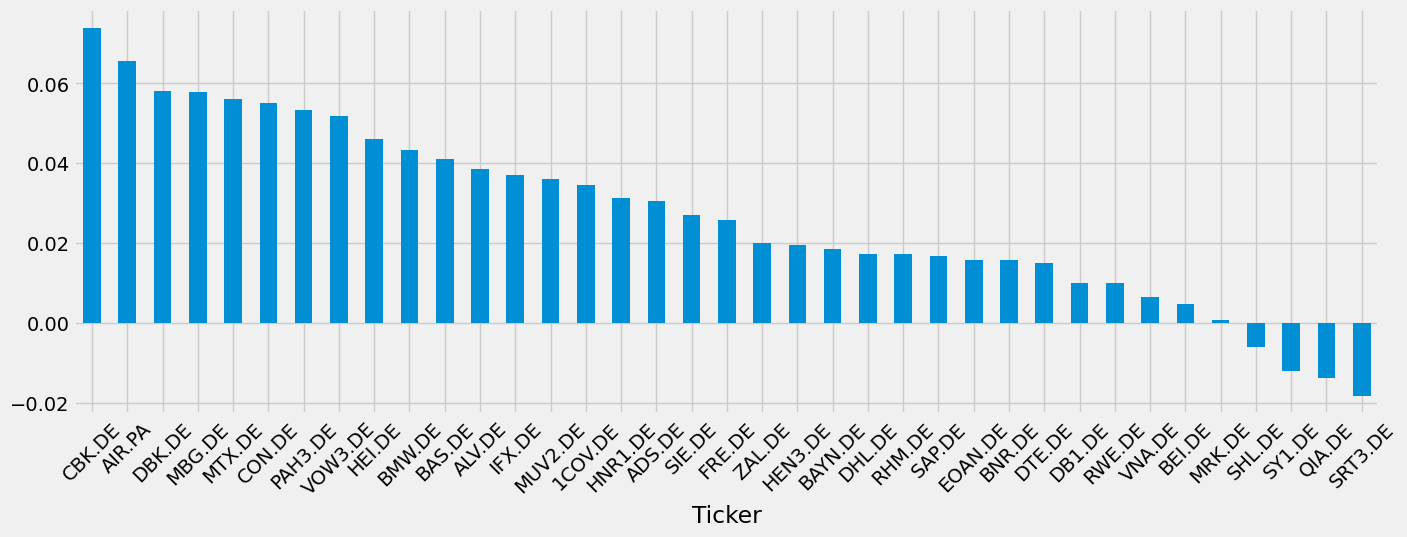

In [34]:
# View first PCA - DAX
w_pcs_de.PC1.sort_values(ascending = False).plot.bar(label = 'PC1', rot = 45, figsize = (15, 5))

<Axes: xlabel='Ticker'>

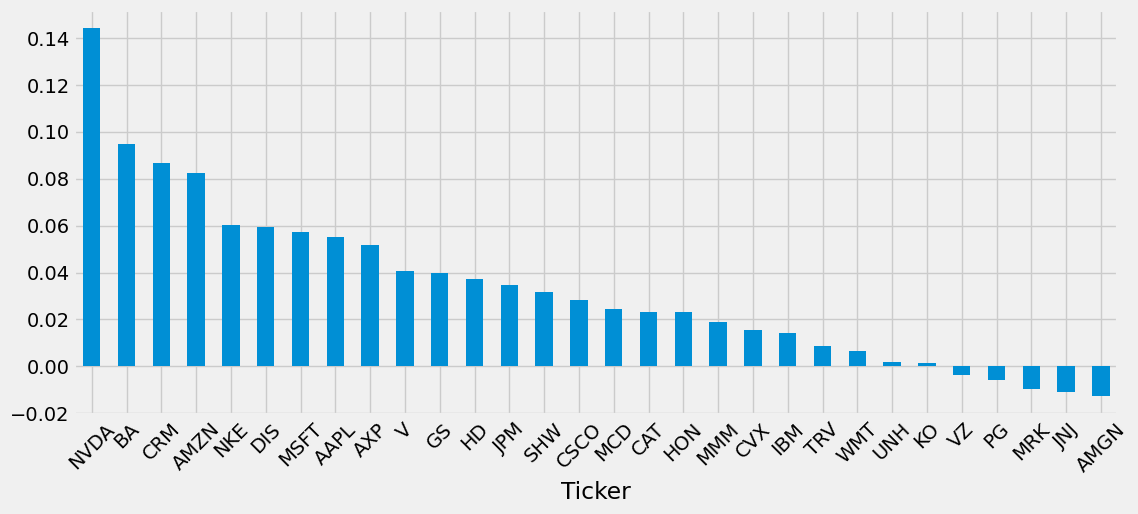

In [35]:
# View first PCA - DJIA
w_pcs_us.PC1.sort_values(ascending = False).plot.bar(label = 'PC1', rot = 45, figsize = (12, 5))

In [36]:
## In-sample results for eigen portfolios
eigen_port_de = (Returns['DAX-40'] @ w_pcs_de)
eigen_port_us = (Returns['DJIA-30'] @ w_pcs_us)

In [37]:
## In-sample: Top 10 'Low Volatility Eigen Portoflios' - lvep
# DAX
lvep_de = eigen_port_de.describe().iloc[1:,:].T.nsmallest(10, 'std').T.mul(100).round(2)
lvep_de

,PC37,PC33,PC29,PC32,PC7,PC1,PC2,PC8,PC18,PC17
mean,0.17,0.20,0.37,0.53,0.15,0.27,0.09,0.03,0.32,0.03
std,1.88,3.51,3.91,4.04,4.11,4.48,4.78,5.00,5.21,5.22
min,-10.78,-11.52,-13.21,-15.87,-22.07,-23.61,-13.51,-31.64,-19.17,-16.35
25%,-0.95,-2.00,-2.10,-1.91,-1.93,-1.78,-2.80,-2.36,-2.23,-3.06
50%,0.25,-0.13,0.28,0.52,0.16,0.58,0.80,0.13,0.25,0.40
75%,1.28,2.28,3.01,2.95,2.57,2.22,2.76,2.58,2.85,3.54
max,5.13,12.02,10.59,9.68,17.25,17.34,23.93,19.37,16.66,13.62


In [38]:
# DJIA
lvep_us = eigen_port_us.describe().iloc[1:,:].T.nsmallest(10, 'std').T.mul(100).round(2)
lvep_us

,PC30,PC29,PC18,PC27,PC8,PC23,PC1,PC22,PC5,PC21
mean,0.18,0.16,0.05,0.39,0.45,-0.07,0.41,0.38,0.13,-0.27
std,1.66,2.54,2.85,2.85,2.87,3.52,3.71,3.89,3.96,4.19
min,-4.94,-6.04,-7.04,-7.16,-12.25,-13.47,-17.97,-11.14,-12.78,-13.63
25%,-0.83,-1.48,-1.73,-1.29,-0.80,-2.21,-1.13,-1.94,-2.15,-2.87
50%,0.13,0.17,0.10,0.56,0.35,0.17,0.74,0.64,0.36,-0.72
75%,1.21,1.61,1.53,2.23,1.90,2.37,2.62,2.98,2.46,2.39
max,5.15,8.52,7.43,8.16,9.93,9.04,8.24,11.90,9.69,10.68


In [134]:
## In-sample: 'High Sharpe Ratio Eigen Portoflios': srep

# derive function to compute expected returns, volatility and sharpe ratio
def perf_metrics(port_ret: pd.DataFrame, sig: float=0.05) -> pd.Series:
  """ Takes in portfolio return df, and computes and returns metrics
  """

  # Compute portfolio performance metrics
  ann_ret = np.nanmean(port_ret) * 52 * 100                    # annualized average returns
  vol = np.nanstd(port_ret) * np.sqrt(52) * 100                # annualized volatility
  SR = ann_ret / vol                                            # Sharpe ratio
  mets = [ann_ret, vol, SR]
  names = ['ann_ret', 'vol', 'SR']
  metrics = pd.Series(mets, index = names)
  return metrics

In [40]:
# Sort by Sharpe ratio and obtain first 10
srep_de = eigen_port_de.apply(perf_metrics).T.sort_values(by = 'SR', ascending = False).T.iloc[:, :10]
srep_us = eigen_port_us.apply(perf_metrics).T.sort_values(by = 'SR', ascending = False).T.iloc[:, :10]
srep_de

,PC13,PC27,PC36,PC32,PC5,PC29,PC37,PC23,PC31,PC11
ann_ret,68.948917,119.038220,804.832896,27.690209,458.331736,19.065960,8.760582,53.639947,72.967671,83.973807
vol,54.360146,108.646639,782.711567,29.038706,556.571144,28.102536,13.533531,100.393904,143.942365,171.669897
SR,1.268373,1.095646,1.028262,0.953562,0.823492,0.678443,0.647324,0.534295,0.506923,0.489159


In [41]:
srep_us

,PC8,PC24,PC27,PC6,PC1,PC30,PC22,PC26,PC25,PC29
ann_ret,23.344845,72.270919,20.190532,543.523347,21.189945,9.180979,19.866667,26.779726,26.096847,8.406460
vol,20.642669,64.150786,20.515518,611.407063,26.675553,11.923257,27.987770,42.918671,45.138119,18.236589
SR,1.130902,1.126579,0.984159,0.888971,0.794358,0.770006,0.709834,0.623964,0.578155,0.460967


In [43]:
# Eigen portfolios loadings with the lowest in-sample variance/standard deviation (Top 10)
nameslvep_de, nameslvep_us = list(lvep_de.columns), list(lvep_us.columns)
nameslvep_de, nameslvep_us

(['PC37', 'PC33', 'PC29', 'PC32', 'PC7', 'PC1', 'PC2', 'PC8', 'PC18', 'PC17'],
 ['PC30', 'PC29', 'PC18', 'PC27', 'PC8', 'PC23', 'PC1', 'PC22', 'PC5', 'PC21'])

In [44]:
# Eigen portfolios loadings with the highest in-sample Sharpe Ratio (Top 10)
namessrep_de, namessrep_us = list(srep_de.columns), list(srep_us.columns)
print(namessrep_de)
namessrep_us

['PC13', 'PC27', 'PC36', 'PC32', 'PC5', 'PC29', 'PC37', 'PC23', 'PC31', 'PC11']


['PC8', 'PC24', 'PC27', 'PC6', 'PC1', 'PC30', 'PC22', 'PC26', 'PC25', 'PC29']

Below we proceed to obtain the average of the weights attributed to each constituent by the first 10 pca loadings.

This is just to examine weight distribution for the pca factors. Moreover, the (normalized) weights can be used to test a trading or investment strategy.  

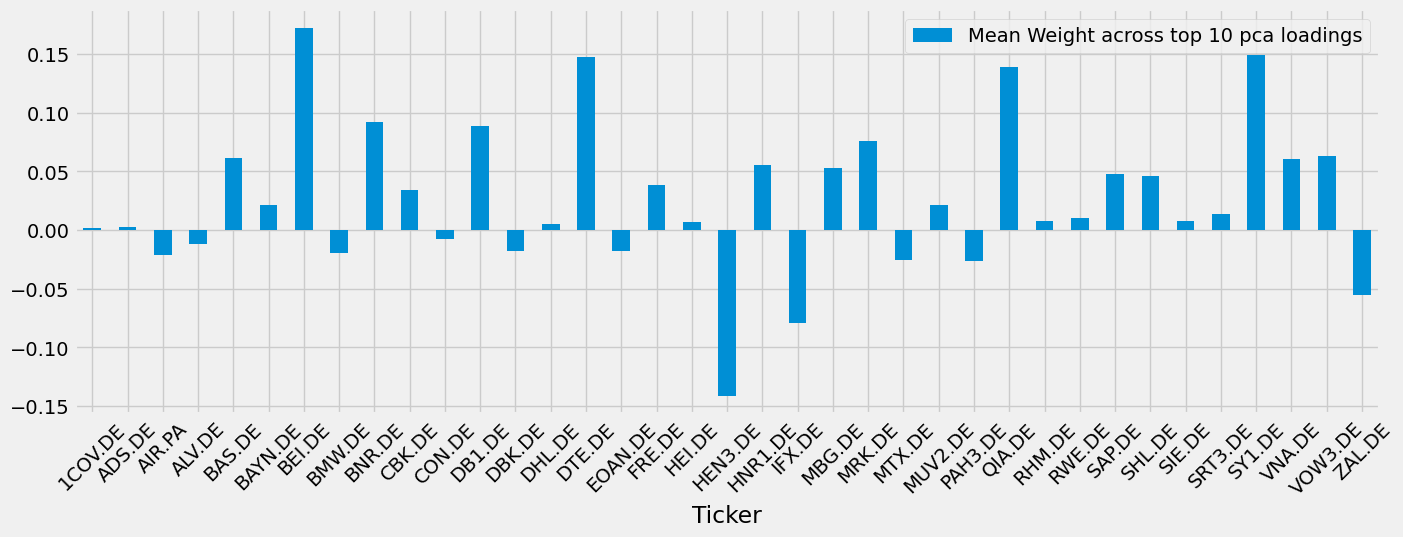

1.0000000000000002

In [45]:
# View DAX - loadings obtained as per top 10 variance.
w_pcs_de[nameslvep_de].mean(axis = 1).plot.bar(label = 'Mean Weight across top 10 pca loadings', rot = 45, figsize = (15, 5))
plt.legend()
plt.show()

w_pcs_de[nameslvep_de].mean(axis =1).sum()

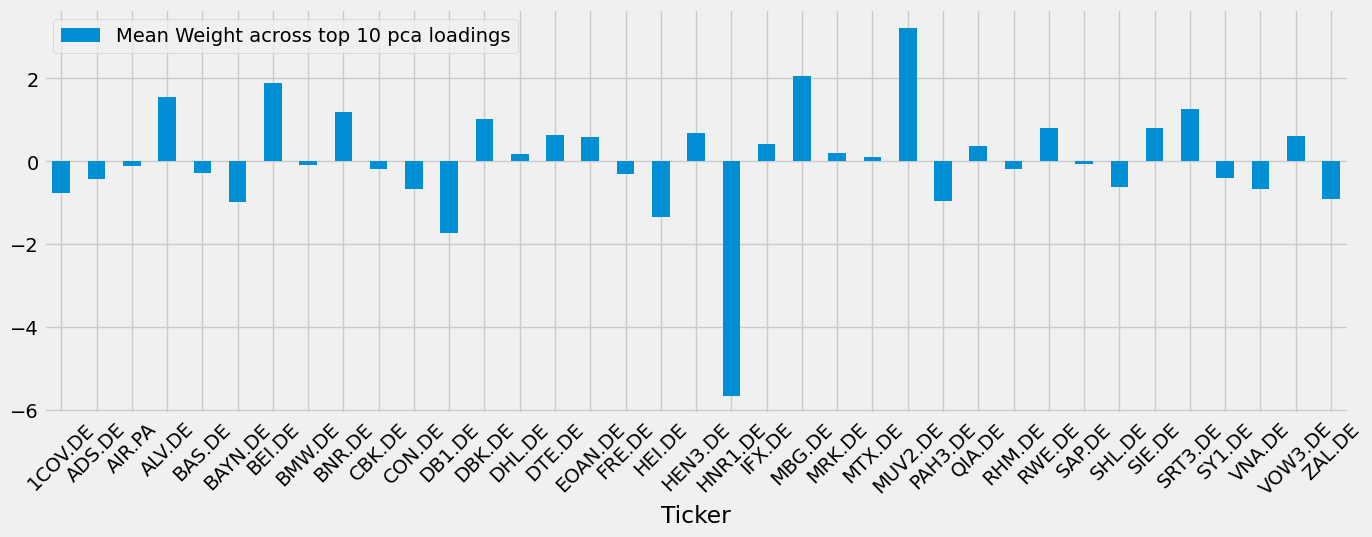

0.9999999999999992

In [46]:
# View DAX - loadings obtained as per top 10 Sharpe Ratio.
w_pcs_de[namessrep_de].mean(axis = 1).plot.bar(label = 'Mean Weight across top 10 pca loadings', rot = 45,  figsize = (15, 5))
plt.legend()
plt.show()

w_pcs_de[namessrep_de].mean(axis =1).sum()

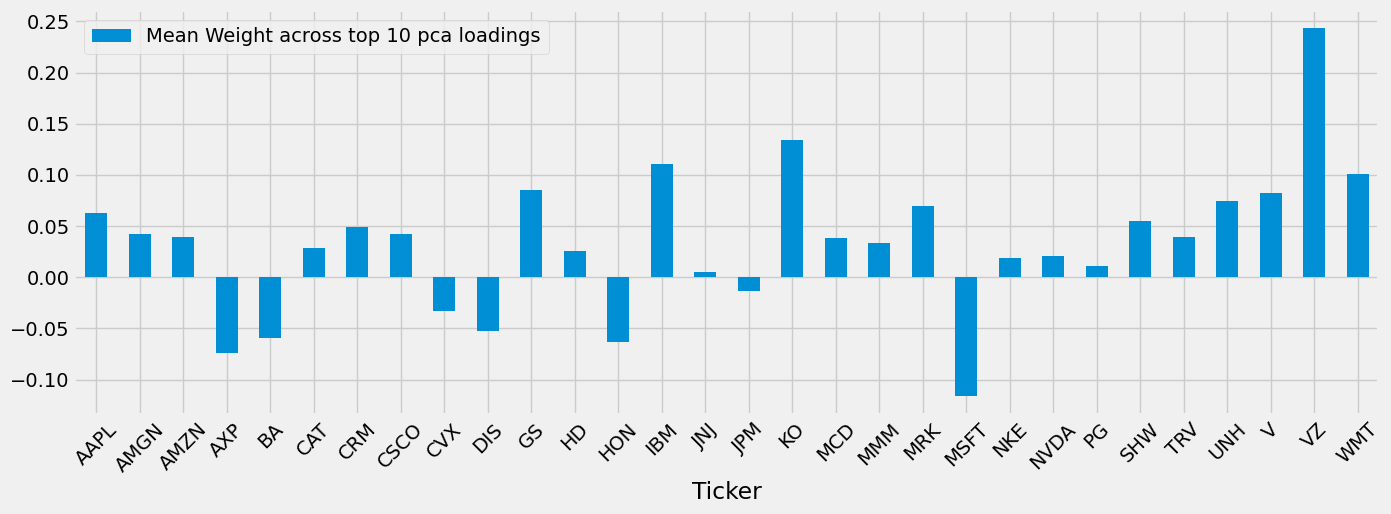

1.0

In [47]:
# View DJIA loadings obtained as per top 10 variance.
w_pcs_us[nameslvep_us].mean(axis = 1).plot.bar(label = 'Mean Weight across top 10 pca loadings', rot = 45, figsize = (15, 5))
plt.legend()
plt.show()

w_pcs_us[nameslvep_us].mean(axis =1).sum()

0.9999999999999992

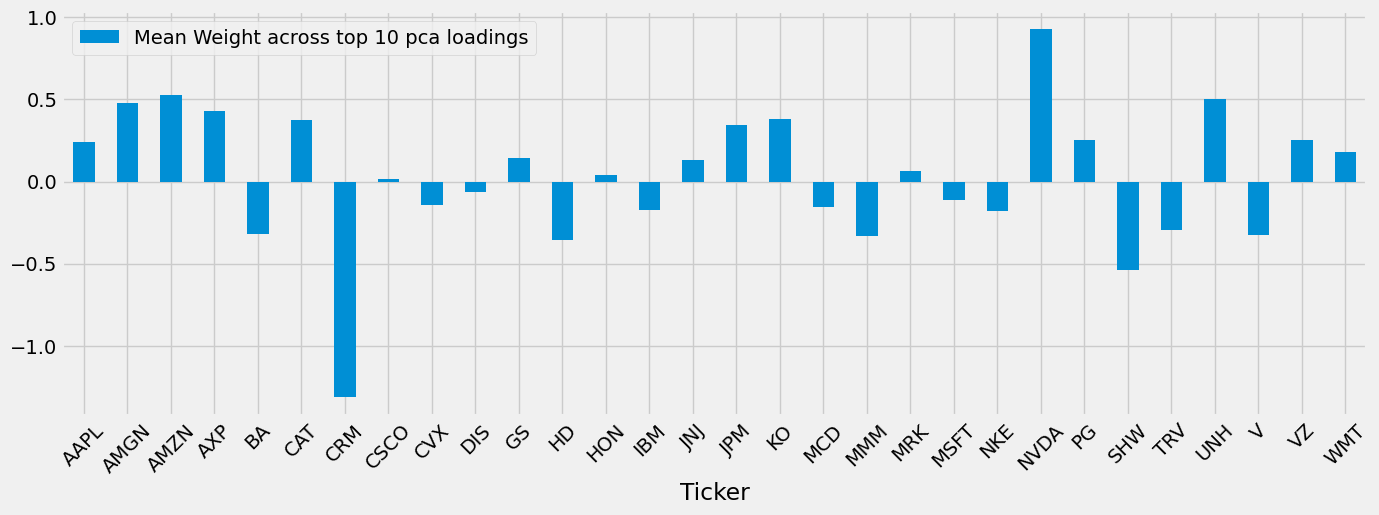

In [48]:
# View DJIA - loadings obtained as per top 10 Sharpe Ratio.
w_pcs_us[namessrep_us].mean(axis = 1).plot.bar(label = 'Mean Weight across top 10 pca loadings', rot = 45, figsize = (15, 5))
plt.legend()
plt.show

w_pcs_us[namessrep_us].mean(axis =1).sum()

> It is often said data is the new oil. However oil is a finite resource that must be extracted and refined, whereas data is an infinite resource that is constantly being generated and refined -  Halevey, Peter Norvig, Fernando Preira.

In [178]:
#  Function to compute out-sample portfolio performance metrics

def MaxDrawdown(returns: pd.DataFrame)-> float:
  """ Takes in portfolio return data, and computes maximum drawdown from peak to trough
  """
  cum_ret = (1 + returns).cumprod()
  cum_ret_max = cum_ret.cummax()
  max_drawdown = (cum_ret - cum_ret_max) / cum_ret_max

  return max_drawdown.min()

def perf_metrics(port_ret: pd.DataFrame, sig: float=0.05) -> list[float]:

  """ Takes in (weeekly) portfolio return df, and computes metrics.
  sig: the significance level for VaR and CVaR, defaul 5%
  """

  # Compute portfolio performance metrics
  ann_ret = np.nanmean(port_ret) * 52 * 100                     # annualized average returns
  vol = np.nanstd(port_ret) * np.sqrt(52) * 100                 # annualized volatility
  SR = ann_ret / vol                                            # Sharpe ratio
  geo_mean = (np.exp(np.log(1 + port_ret)).mean()) - 1          # geometric returns
  ann_gm = ((1 + geo_mean) ** len(port_ret) - 1 ) * 100         # annualized geometric returns
  #cumret = (np.exp(port_ret.sum()) - 1) * 100                  # cumulative returns same as Ann. Geo Returns
  d_vol = np.nanstd(port_ret[port_ret<0]) * np.sqrt(52) * 100   # annualized downside deviation
  MDD = MaxDrawdown(port_ret) * 100                             # maximum drawdown (daily)
  VaR = port_ret.quantile(sig)                                  # daily VaR
  CVaR = (port_ret[port_ret<=VaR].mean())                       # daily CVaR

  # Metrics
  mets = [ann_ret, vol, SR, ann_gm, d_vol, MDD, VaR * 100, CVaR * 100]

  return mets

In [51]:
# @title Out-Sample Result
# Obtain tickers
# This is the column names of the data frames used for in-sample estimation
o_tickers = {'DAX-40': list(Returns['DAX-40'].columns), 'DJIA-30':  list(Returns['DJIA-30'].columns)}
[len(ticker) for ticker in o_tickers.values()]

[37, 30]

In [52]:
# Download out-sample data
start = '2023-07-01'
end = '2024-11-30'
freq = '1wk'
Data_test = ({key: read_data(ticker, start, end, freq) for key, ticker in
           o_tickers.items()})

[*********************100%***********************]  37 of 37 completed
[*********************100%***********************]  30 of 30 completed


In [53]:
# Compute returns
Returns_test = {key: data.pct_change().dropna() for key, data in Data_test.items()}

In [54]:
# Out sample eigen portfolio: OS
os_eigen_port_de = (Returns_test['DAX-40'] @ w_pcs_de)
os_eigen_port_us = (Returns_test['DJIA-30'] @ w_pcs_us)

In [55]:
# View head
os_eigen_port_de.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73 entries, 2023-07-10 00:00:00+00:00 to 2024-11-25 00:00:00+00:00
Data columns (total 37 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PC1     73 non-null     float64
 1   PC2     73 non-null     float64
 2   PC3     73 non-null     float64
 3   PC4     73 non-null     float64
 4   PC5     73 non-null     float64
 5   PC6     73 non-null     float64
 6   PC7     73 non-null     float64
 7   PC8     73 non-null     float64
 8   PC9     73 non-null     float64
 9   PC10    73 non-null     float64
 10  PC11    73 non-null     float64
 11  PC12    73 non-null     float64
 12  PC13    73 non-null     float64
 13  PC14    73 non-null     float64
 14  PC15    73 non-null     float64
 15  PC16    73 non-null     float64
 16  PC17    73 non-null     float64
 17  PC18    73 non-null     float64
 18  PC19    73 non-null     float64
 19  PC20    73 non-null     float64
 20  PC21    73 non-null     floa

In [75]:
import warnings
warnings.filterwarnings('ignore')

In [78]:
## DAX
# Use color map summer on rows: green to yellow
#out_results =  {key: df.apply(perf_metrics).T for key, df in .items()}
out_results = os_eigen_port_de.apply(perf_metrics)
out_results.index = ['Annz. Ret', 'Annz. Vol', 'Sharpe Ratio', 'Annz. G.Ret',   'Down_Vol', 'MaxDrawD', 'VaR_5%', 'CVaR_5%']
out_results.T.nsmallest(15, 'Annz. Vol').T.style.format(precision=2).background_gradient(cmap = 'summer', axis=1)

,PC1,PC37,PC7,PC29,PC2,PC33,PC8,PC18,PC4,PC32,PC3,PC19,PC17,PC13,PC14
Annz. Ret,14.13,18.82,4.46,45.21,-0.63,-11.85,-5.61,4.37,93.19,34.46,17.92,45.41,27.75,-98.30,60.04
Annz. Vol,13.73,13.94,21.58,27.37,28.02,29.29,31.67,31.80,32.51,34.42,37.32,39.42,44.69,51.38,55.76
Sharpe Ratio,1.03,1.35,0.21,1.65,-0.02,-0.40,-0.18,0.14,2.87,1.00,0.48,1.15,0.62,-1.91,1.08
Annz. G.Ret,21.90,30.18,6.46,88.12,-0.88,-15.34,-7.58,6.32,265.73,61.95,28.55,88.66,47.47,-75.17,131.18
Down_Vol,9.07,10.30,11.68,16.56,13.95,16.21,18.91,19.15,18.33,26.91,21.55,25.08,27.72,29.18,35.78
MaxDrawD,-10.64,-11.48,-22.15,-13.08,-26.37,-26.34,-32.01,-30.50,-18.48,-21.26,-34.05,-24.04,-28.72,-78.56,-31.60
VaR_5%,-2.59,-2.97,-4.14,-5.44,-5.59,-6.79,-7.80,-6.47,-5.19,-6.40,-8.25,-8.77,-9.20,-12.31,-12.13
CVaR_5%,-4.11,-4.29,-5.59,-7.22,-6.83,-8.44,-8.71,-8.86,-7.84,-11.12,-9.98,-10.66,-11.95,-15.04,-14.68


In [57]:
print(nameslvep_de)
print(namessrep_de )

['PC37', 'PC33', 'PC29', 'PC32', 'PC7', 'PC1', 'PC2', 'PC8', 'PC18', 'PC17']
['PC13', 'PC27', 'PC36', 'PC32', 'PC5', 'PC29', 'PC37', 'PC23', 'PC31', 'PC11']


In [79]:
## DJIA
out_results = os_eigen_port_us.apply(perf_metrics)
out_results.index = ['Annz. Ret', 'Annz. Vol', 'Sharpe Ratio', 'Annz. G.Ret',   'Down_Vol', 'MaxDrawD', 'VaR_5%', 'CVaR_5%']
out_results.T.nsmallest(15, 'Annz. Vol').T.style.format(precision=2).background_gradient(cmap = 'summer', axis=1)

,PC30,PC8,PC1,PC18,PC2,PC5,PC11,PC29,PC22,PC23,PC27,PC21,PC16,PC13,PC12
Annz. Ret,17.52,19.28,34.12,36.71,8.17,28.22,0.04,29.43,57.27,15.11,52.15,33.02,23.36,7.97,76.04
Annz. Vol,11.09,13.36,17.04,18.74,22.56,24.25,25.18,25.97,27.60,27.75,30.60,36.51,37.01,47.91,49.18
Sharpe Ratio,1.58,1.44,2.00,1.96,0.36,1.16,0.00,1.13,2.07,0.54,1.70,0.90,0.63,0.17,1.55
Annz. G.Ret,27.82,31.02,61.19,67.11,12.14,48.46,0.05,50.98,122.47,23.60,107.18,58.74,38.70,11.83,188.56
Down_Vol,5.30,7.96,9.89,10.41,15.11,18.77,15.37,18.49,17.56,19.86,17.96,20.66,24.18,25.16,27.92
MaxDrawD,-6.39,-5.66,-11.61,-9.95,-19.00,-15.19,-28.31,-24.60,-19.20,-26.58,-16.85,-40.06,-22.64,-39.55,-31.25
VaR_5%,-2.05,-2.68,-3.24,-3.62,-5.69,-4.54,-5.68,-5.55,-6.37,-7.30,-5.15,-6.31,-7.37,-10.18,-9.45
CVaR_5%,-2.39,-3.58,-4.32,-4.61,-6.93,-8.24,-6.87,-7.82,-7.34,-9.35,-8.19,-9.52,-11.37,-12.06,-12.31


In [59]:
nameslvep_us, namessrep_us

(['PC30', 'PC29', 'PC18', 'PC27', 'PC8', 'PC23', 'PC1', 'PC22', 'PC5', 'PC21'],
 ['PC8', 'PC24', 'PC27', 'PC6', 'PC1', 'PC30', 'PC22', 'PC26', 'PC25', 'PC29'])

> A noticeable pattern, (some) extreme pca's (last ones and first ones. e.g if 1-30 stocks: then the 1,..5,25,..30 'th' pca) seems to replicate their peerformance out-sample.  

# **ML Asset Allocation**

Machine Learning (ML) asset allocation refers to the use of ML algorithms and techniques to determine the optimal assets weights in an investment portfolio often with the goal to mitigate risk while aiming for maximum returns on investment. There are wide range activities that can be carried out using ML algorithms techniques, such as utilizing supervise learning models to predict stock price percentage or market movements, utilizing clustering to classify stocks into different regimes based on historical data, or clustering a collection stocks into groups with similar characteristics, applying genetic algorithm to find optimal portfolio wweights that balances risk ad return, or applying (hierarchical) clustering for weight allocation as we'll see below.

# **Clustering**

- **Supervised Learning algos** are types of ML algorithm that can be trained on a set of input data (features) along with a desired output data (labels), such that the model is capable of disecting and uncovering hidden patterns between the input and out data.
- **Unsupervised Learning**  are types of ML algorthings that tries to extract structure from a given dataset with no labels given, **clustering** is an example of this technique.
- **Reinforcement learning**: Is a ML algorithm that allows for the specification of one or more intelligent agents whose decisions evolve as the model is trained according to a specified cost function.

# **K-Means Clustering for Portfolio Allocation**

K-Means clustering is a popular unsupervised ML algorithm that can be applied to portfolio optimzation.

For example by grouping similar assets together based on characteristics (e.g., historical data returns,  average (expected) returns, volatility, fundamentals such as Price to Earnings ratio,...)

In this section of the project we want to implement the k-means clustering algorithm in the context of portfolio construction, namely: in an equally weighted framework.  


In [267]:
# Functions to compute rolling return spread
def max_min_spread(df: pd.DataFrame):
  return df.max() - df.min()

In [268]:
# Obtain rolling data for DAX
# Compute rolling mean returns spread, expceted return and stabdard deviation, then concat result
rolling_spread = Returns['DAX-40'].rolling(150).apply(max_min_spread).dropna(axis= 0).T  # rolling return spread
rolling_mean = Returns['DAX-40'].rolling(150).mean().dropna(axis = 0).T                  # rolling expected return
rolling_vol = Returns['DAX-40'].rolling(150).std().dropna(axis= 0).T                     # rolling standard deviation
kmeans_data_de = pd.concat([rolling_spread, rolling_mean, rolling_vol ], axis = 1)       # concat data
kmeans_data_de.head()

Date,2022-11-14 00:00:00+00:00,2022-11-21 00:00:00+00:00,2022-11-28 00:00:00+00:00,2022-12-05 00:00:00+00:00,2022-12-12 00:00:00+00:00,2022-12-19 00:00:00+00:00,2022-12-26 00:00:00+00:00,2023-01-02 00:00:00+00:00,2023-01-09 00:00:00+00:00,2023-01-16 00:00:00+00:00,...,2023-04-24 00:00:00+00:00,2023-05-01 00:00:00+00:00,2023-05-08 00:00:00+00:00,2023-05-15 00:00:00+00:00,2023-05-22 00:00:00+00:00,2023-05-29 00:00:00+00:00,2023-06-05 00:00:00+00:00,2023-06-12 00:00:00+00:00,2023-06-19 00:00:00+00:00,2023-06-26 00:00:00+00:00
Ticker,,,,,,,,,,,,,,,,,,,,,
1COV.DE,0.309305,0.309305,0.309305,0.309305,0.309305,0.309305,0.309305,0.343878,0.343878,0.343878,...,0.045222,0.045136,0.045141,0.045127,0.045089,0.044962,0.044932,0.044645,0.045882,0.045733
ADS.DE,0.476309,0.476309,0.476309,0.476309,0.476309,0.476309,0.476309,0.476309,0.476309,0.476309,...,0.050788,0.051030,0.051073,0.051042,0.051038,0.051080,0.051079,0.051620,0.051339,0.051046
AIR.PA,0.702020,0.702020,0.702020,0.702020,0.702020,0.702020,0.702020,0.702020,0.702020,0.702020,...,0.047042,0.047070,0.046249,0.046189,0.046264,0.046282,0.046192,0.046115,0.045312,0.045332
ALV.DE,0.408820,0.408820,0.408820,0.408820,0.408820,0.408820,0.408820,0.408820,0.408820,0.408820,...,0.033391,0.033649,0.033709,0.033608,0.033661,0.033656,0.033656,0.033480,0.033483,0.033464
BAS.DE,0.397416,0.397416,0.397416,0.397416,0.397416,0.397416,0.397416,0.397416,0.397416,0.397416,...,0.042613,0.043243,0.043232,0.043146,0.043159,0.043050,0.043072,0.042142,0.042539,0.042630


In [269]:
# Obtain rolling data for DJIA
rolling_spread = Returns['DJIA-30'].rolling(150).apply(max_min_spread).dropna(axis= 0).T  # rolling return spread
rolling_mean = Returns['DJIA-30'].rolling(150).mean().dropna(axis = 0).T                  # rolling expected return
rolling_std = Returns['DJIA-30'].rolling(150).std().dropna(axis= 0).T                     # rolling standard deviation
kmeans_data_us = pd.concat([rolling_spread, rolling_mean, rolling_std ], axis = 1)        # concat data
kmeans_data_us.head()

Date,2022-11-16 00:00:00+00:00,2022-11-23 00:00:00+00:00,2022-11-30 00:00:00+00:00,2022-12-07 00:00:00+00:00,2022-12-14 00:00:00+00:00,2022-12-21 00:00:00+00:00,2022-12-28 00:00:00+00:00,2023-01-04 00:00:00+00:00,2023-01-11 00:00:00+00:00,2023-01-18 00:00:00+00:00,...,2023-04-26 00:00:00+00:00,2023-05-03 00:00:00+00:00,2023-05-10 00:00:00+00:00,2023-05-17 00:00:00+00:00,2023-05-24 00:00:00+00:00,2023-05-31 00:00:00+00:00,2023-06-07 00:00:00+00:00,2023-06-14 00:00:00+00:00,2023-06-21 00:00:00+00:00,2023-06-28 00:00:00+00:00
Ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,0.335190,0.335190,0.335190,0.335190,0.335190,0.335190,0.335190,0.335190,0.335190,0.335190,...,0.043466,0.043383,0.043376,0.043358,0.043317,0.043317,0.043191,0.040857,0.040865,0.040685
AMGN,0.168709,0.168709,0.168709,0.168709,0.168709,0.168709,0.168709,0.168709,0.168709,0.168709,...,0.030229,0.030074,0.030167,0.029599,0.029633,0.029609,0.029598,0.029454,0.029377,0.029284
AMZN,0.365969,0.365969,0.365969,0.365969,0.365969,0.365969,0.365969,0.365969,0.365969,0.365969,...,0.055559,0.055413,0.055656,0.055205,0.055363,0.055444,0.055325,0.055200,0.055223,0.054884
AXP,0.366033,0.366033,0.366033,0.366033,0.366033,0.366033,0.366033,0.366033,0.366033,0.366033,...,0.046477,0.046192,0.046132,0.046117,0.046159,0.046642,0.046611,0.046691,0.045931,0.045655
BA,0.876358,0.876358,0.876358,0.876358,0.876358,0.876358,0.876358,0.876358,0.876358,0.876358,...,0.053917,0.053755,0.053715,0.053674,0.053677,0.053678,0.053771,0.053784,0.053310,0.053103


In [273]:
## DAX We want to obtain 4 clusters
from sklearn.cluster import KMeans
n = 4
kmeans = KMeans(n_clusters=n, random_state=75)
kmeans.fit(kmeans_data_de)
labels_de = kmeans.labels_ # kmeans.fit_predict(Returns['DAX-40']) # kmeans.labels_
#centers_de = kmeans.cluster_centers_
#centers_de
labels_de

array([2, 0, 3, 2, 2, 2, 1, 2, 1, 3, 0, 1, 0, 1, 1, 1, 2, 2, 1, 2, 2, 0,
       1, 0, 2, 0, 1, 3, 2, 0, 1, 2, 0, 1, 1, 0, 3], dtype=int32)

In [274]:
## DJIA
from sklearn.cluster import KMeans
n = 4
kmeans = KMeans(n_clusters=n, random_state=75)
kmeans.fit(kmeans_data_us)
labels_us = kmeans.labels_  #kmeans.fit_predict(Returns['DAX-40']) # kmeans.labels_
#centers_us = kmeans.cluster_centers_
#centers_us
labels_us

array([1, 2, 1, 1, 3, 2, 1, 2, 2, 1, 2, 0, 0, 2, 2, 1, 0, 0, 2, 2, 2, 1,
       1, 2, 1, 0, 2, 2, 2, 2], dtype=int32)

In [275]:
# DAX
clusters_de = pd.DataFrame({'labels': labels_de, 'column_name': kmeans_data_de.index}).sort_values(by = 'labels')

# Group the labels
clusters = clusters_de.groupby('labels')['column_name'].apply(list).to_dict()

# Now for each cluster, compute an equally weighted portfolio
# Both in-sample and out-sample
# compute in-sample results for each cluster
rets_clusters_is = {}
for key, value in clusters.items():
  data = Returns['DAX-40'][value]
  rets_clusters_is[key] = data.mean(axis = 1)
print('Number of observation, Ex-ANte: ',len(Returns['DAX-40']), '\n')

# Compute and store equally weighted returns for each cluster,
# then use overall equally weighted as benchmark
rets_clusters = {}
for key, value in clusters.items():
  data = Returns_test['DAX-40'][value]
  rets_clusters[key] = data.mean(axis = 1)
  print(key, value)
print('Number of observation, Ex-Post: ',len(Returns_test['DAX-40']))

Number of observation, Ex-ANte:  182 

0 ['MTX.DE', 'ADS.DE', 'MBG.DE', 'PAH3.DE', 'SRT3.DE', 'VOW3.DE', 'SAP.DE', 'CON.DE', 'DBK.DE']
1 ['QIA.DE', 'EOAN.DE', 'DTE.DE', 'DHL.DE', 'HEN3.DE', 'BNR.DE', 'SHL.DE', 'BEI.DE', 'SY1.DE', 'VNA.DE', 'MRK.DE', 'DB1.DE']
2 ['RWE.DE', 'SIE.DE', 'MUV2.DE', '1COV.DE', 'HNR1.DE', 'HEI.DE', 'FRE.DE', 'BMW.DE', 'BAYN.DE', 'BAS.DE', 'ALV.DE', 'IFX.DE']
3 ['RHM.DE', 'CBK.DE', 'AIR.PA', 'ZAL.DE']
Number of observation, Ex-Post:  73


In [276]:
# DAX  - InSample results
# compute stats for each weighted clusters
rets_clusters_is_df = pd.DataFrame(rets_clusters_is)
rets_clusters_is_df['EqW'] = Returns['DAX-40'].mean(axis = 1)
rets_clusters_is_df.head()
clusters_res = rets_clusters_is_df.apply(perf_metrics).T
clusters_res.columns = ['Annz. Ret', 'Annz. Vol', 'Sharpe Ratio', 'Annz. G.Ret',   'Down_Vol', 'MaxDrawD', 'VaR_5%', 'CVaR_5%']
clusters_res

,Annz. Ret,Annz. Vol,Sharpe Ratio,Annz. G.Ret,Down_Vol,MaxDrawD,VaR_5%,CVaR_5%
0,12.344493,32.023034,0.385488,53.963477,25.409010,-40.628116,-5.851390,-10.370643
1,9.182016,17.752955,0.517211,37.862573,15.837378,-23.536379,-3.518858,-6.028055
2,12.747523,27.025195,0.471690,56.145385,23.811034,-39.532340,-5.246495,-9.034186
3,19.832817,35.000184,0.566649,99.936213,25.248523,-46.308189,-7.044963,-10.815382
EqW,12.259086,24.254711,0.505431,53.505012,21.468859,-35.437616,-4.403343,-8.041401


In [278]:
# @title Out-sample Kmeans Equally weighted
# compute stats for each weighted clusters
rets_clusters_df = pd.DataFrame(rets_clusters)
rets_clusters_df['EqW'] = Returns_test['DAX-40'].mean(axis = 1)
rets_clusters_df.head()
results = rets_clusters_df.apply(perf_metrics).T
results.columns = ['Annz. Ret', 'Annz. Vol', 'Sharpe Ratio', 'Annz. G.Ret',   'Down_Vol', 'MaxDrawD', 'VaR_5%', 'CVaR_5%']
results

,Annz. Ret,Annz. Vol,Sharpe Ratio,Annz. G.Ret,Down_Vol,MaxDrawD,VaR_5%,CVaR_5%
0,8.964198,16.859717,0.531693,13.398185,8.964031,-15.774865,-3.553159,-4.278809
1,12.157904,11.958955,1.016636,18.587281,6.652920,-7.598564,-2.572454,-3.104981
2,8.801985,14.176078,0.620904,13.140685,8.087246,-11.207353,-3.010059,-3.725693
3,35.935166,21.863396,1.643622,65.324384,14.850407,-13.233337,-4.789364,-6.047396
EqW,12.863165,12.755673,1.008427,19.764373,7.561892,-11.047491,-2.738583,-3.149897


- Results shows that, with in-sample the third cluster achieved superior risk-adjusted returns. Proceeding to choose a portfolio based on that would result to best performing portfolio/cluster including againts the benchmark.

In [279]:
# DJIA
clusters_us = pd.DataFrame({'labels': labels_us, 'column_name': kmeans_data_us.index}).sort_values(by = 'labels')


# Group the labels
clusters = clusters_us.groupby('labels')['column_name'].apply(list).to_dict()

# Now for each cluster, compute an equally weighted portfolio
# compute in-sample results for each cluster
rets_clusters_is = {}
for key, value in clusters.items():
  data = Returns['DJIA-30'][value]
  rets_clusters_is[key] = data.mean(axis = 1)
  #print(key, value)
print('Number of observation, In-Sample: ',len(Returns['DJIA-30']), '\n')

# Compute and store clusters weights
rets_clusters = {}
for key, value in clusters.items():
  data = Returns_test['DJIA-30'][value]
  rets_clusters[key] = data.mean(axis = 1)
  print(key, value)
print('Number of observation, Out-Sample: ', len(Returns_test['DJIA-30']))

Number of observation, In-Sample:  182 

0 ['KO', 'HON', 'TRV', 'HD', 'MCD']
1 ['AAPL', 'JPM', 'NKE', 'NVDA', 'DIS', 'SHW', 'CRM', 'AXP', 'AMZN']
2 ['UNH', 'MSFT', 'V', 'PG', 'MRK', 'JNJ', 'VZ', 'IBM', 'GS', 'CVX', 'CSCO', 'CAT', 'AMGN', 'MMM', 'WMT']
3 ['BA']
Number of observation, Out-Sample:  73


- For cluster 3 only one asset exist. K-means ddoes not support minimum cluster size from model creation. The algorithm would have to be updated for this to happen.

In [280]:
# DJIA  - InSample results
# compute stats for each weighted clusters
rets_clusters_is_df = pd.DataFrame(rets_clusters_is)
rets_clusters_is_df['EqW'] = Returns['DJIA-30'].mean(axis = 1)
rets_clusters_is_df.head()
clusters_res = rets_clusters_is_df.apply(perf_metrics).T
clusters_res.columns = ['Annz. Ret', 'Annz. Vol', 'Sharpe Ratio', 'Annz. G.Ret',   'Down_Vol', 'MaxDrawD', 'VaR_5%', 'CVaR_5%']
clusters_res

,Annz. Ret,Annz. Vol,Sharpe Ratio,Annz. G.Ret,Down_Vol,MaxDrawD,VaR_5%,CVaR_5%
0,12.642729,19.038642,0.664056,55.575111,17.677522,-28.634790,-3.088391,-6.026714
1,19.645126,26.097792,0.752751,98.632039,21.028585,-39.234015,-6.293680,-8.625582
2,10.914781,15.137520,0.721042,46.465099,11.278727,-22.101212,-3.208294,-4.704034
3,1.156124,51.912638,0.022271,4.128949,40.202482,-65.126766,-9.265891,-15.285755
EqW,13.496587,18.072292,0.746811,60.282643,15.768949,-24.788202,-3.805381,-5.936670


In [281]:
# @title Out-sample Kmeans Equally weighted
# compute stats for each weighted clusters
rets_clusters_df = pd.DataFrame(rets_clusters)
rets_clusters_df['EqW'] = Returns_test['DAX-40'].mean(axis = 1)
rets_clusters_df.head()
results = rets_clusters_df.apply(perf_metrics).T
results.columns = ['Annz. Ret', 'Annz. Vol', 'Sharpe Ratio', 'Annz. G.Ret',   'Down_Vol', 'MaxDrawD', 'VaR_5%', 'CVaR_5%']
results

,Annz. Ret,Annz. Vol,Sharpe Ratio,Annz. G.Ret,Down_Vol,MaxDrawD,VaR_5%,CVaR_5%
0,18.431161,13.402239,1.375230,29.471121,9.103634,-11.479551,-2.643666,-3.946333
1,36.171248,16.877500,2.143164,65.869431,9.446659,-11.143161,-3.233259,-3.964840
2,25.924744,10.232234,2.533635,43.769236,5.218441,-5.840039,-1.892112,-2.163915
3,-16.679410,32.863306,-0.507539,-20.905717,20.993490,-46.951978,-7.761375,-9.738347
EqW,12.863165,12.755673,1.008427,19.764373,7.561892,-11.047491,-2.738583,-3.149897


- With the DJIA constituents, the best performing cluster in-sample still happens to perform well out-sample, althugh coming in sceond when compared to the second best in-sample in terms of superior risk-adjusted returns.  

- I tried variants of clustering in put features, namely based on solely rolling volatility, rolling returns, rolling returns spread, the portfolio with superior results in-sample prevailed out-sample. For instance, if a cluster was chosen based on the lowest volatility in-sample, it resulted in performing better than the others out-of-sample. Results were somewhat consistent.



It would be interesting to try different variant of clustering, then implement a mathematical optimization technique for each cluster and examine their out-sample results.

## **Hierarchical Risk Parity Portfolio**

The Hierarchical Risk Parity portfolio is a novel risk-based investment strategy developed by Marcos Lopez de Prado. It is said to be an unsupervised Machine Learning (ML) inspired portfolio optimization strategy that combines naive risk parity with an unsupervised ML technique - hierarchical clustering. Following a *top-down* approach to attribute weights to assets.

The approach works as follows:
- **Correlation Matrix**: First we start by creating a correlation matrix for all asset in our portfolio. This matrix shows how each asset's return move in relation to others.
- **Distance Matrix**: We convert the correlation matrix into a distnace matrix. An example distance matrix is computed as: $\mathbf{\sqrt{2\, *(1-correlation)}}$ . This implies highly correlated asset would have a small distance, while uncorrelated asset would have large distance.  
-  **Clustering**: Using the obtained distance matrix, we perform hierarchical clustering utilizing a **linkage method**. This groups similar assets together creating a tree like structure called **dendogram**. The clustering starts with individual assets and progressively groups them based on their similarities. Additionally we don't have to gues in advanve, how many clusters there are.
- **Quasi-Diagonalization**: We rearrange the correlation matrix based on the clustering. This creates a quasi-diagonal matrix, where similar assets are grouped together along the diagonal.
- **Recursive Bisection** :  This is where the **top-down** part comes in: **A**.Now we have the clusters, for each sub-clusters we calculate its **variance** using the quasi digonalized matrix. **B**. Allocate portfolio weights to each (parent) cluster inversely proportional to their variances. Proceed to allocate parent clusters weight to each sub-clusters inversely proportional to their variances, repeat this process for each sub-clusters until the individual assets.
- **Final Weights**: The weights of the individual assets are determined by the recursive bisection process. Assets in **lower - variance (risk) clusters** will generally receive **higher weights**.

This approach has the advantage in that it allocates risk, in a manner that avoids the pitfalls associated with traditional portolio optmization such as: sensitivity to estimation errors, ill conditioned covariance matrix leading to sub-optimal weights or difficulty with inverting the covariance matrix making the optimization routine unachievable altogether.



## **Hierarchical Clsutering - Dendogram**
We view the dendogram of the in-sample returns below. There are different options for the measurement of the distance e.g ward, single, centroid, average etc.

Ultimately, we'll use the ward linkage method which aims to minimize variance within each clusters, that is it merges clusters in way that the increase in variance is minimized.   

In [197]:
# Hierarchical Clustering of returns data
# Perfrom necessary imports
from scipy.cluster.hierarchy import dendrogram, linkage

# Compute correlation
corr_de = Returns_mrk['DAX-40'].corr()
corr_us = Returns_mrk['DJIA-30'].corr()

# Compute correlation
corr_de = Returns['DAX-40'].corr(method = 'pearson') # Others: Kendall, Spearman
corr_us = Returns['DJIA-30'].corr(method = 'pearson') # Others: Kendall, Spearman


linkage_de = linkage(corr_de , method='ward')
linkage_us = linkage(corr_us , method='ward')

**Copehnetic Correlation Coefficient**

To get a sense of how well the clustering performed, beside others, one measure is cophentic correlation coefficient, **c**.  The closer c is to 1, the better. Generally c above 0.7 implies a good cluster fit.

In [198]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

# Compute distance matrix
dist_de = pdist(corr_de, metric= 'correlation')
dist_us = pdist(corr_us, metric= 'correlation')

# Compute cophenetic correlation coefficient
c_de, coph_dist_de = cophenet(linkage_de, dist_de)
c_us, coph_dist_us = cophenet(linkage_us, dist_us)

# Print results
c_de, c_us

(0.6666922402852656, 0.7544753878533897)

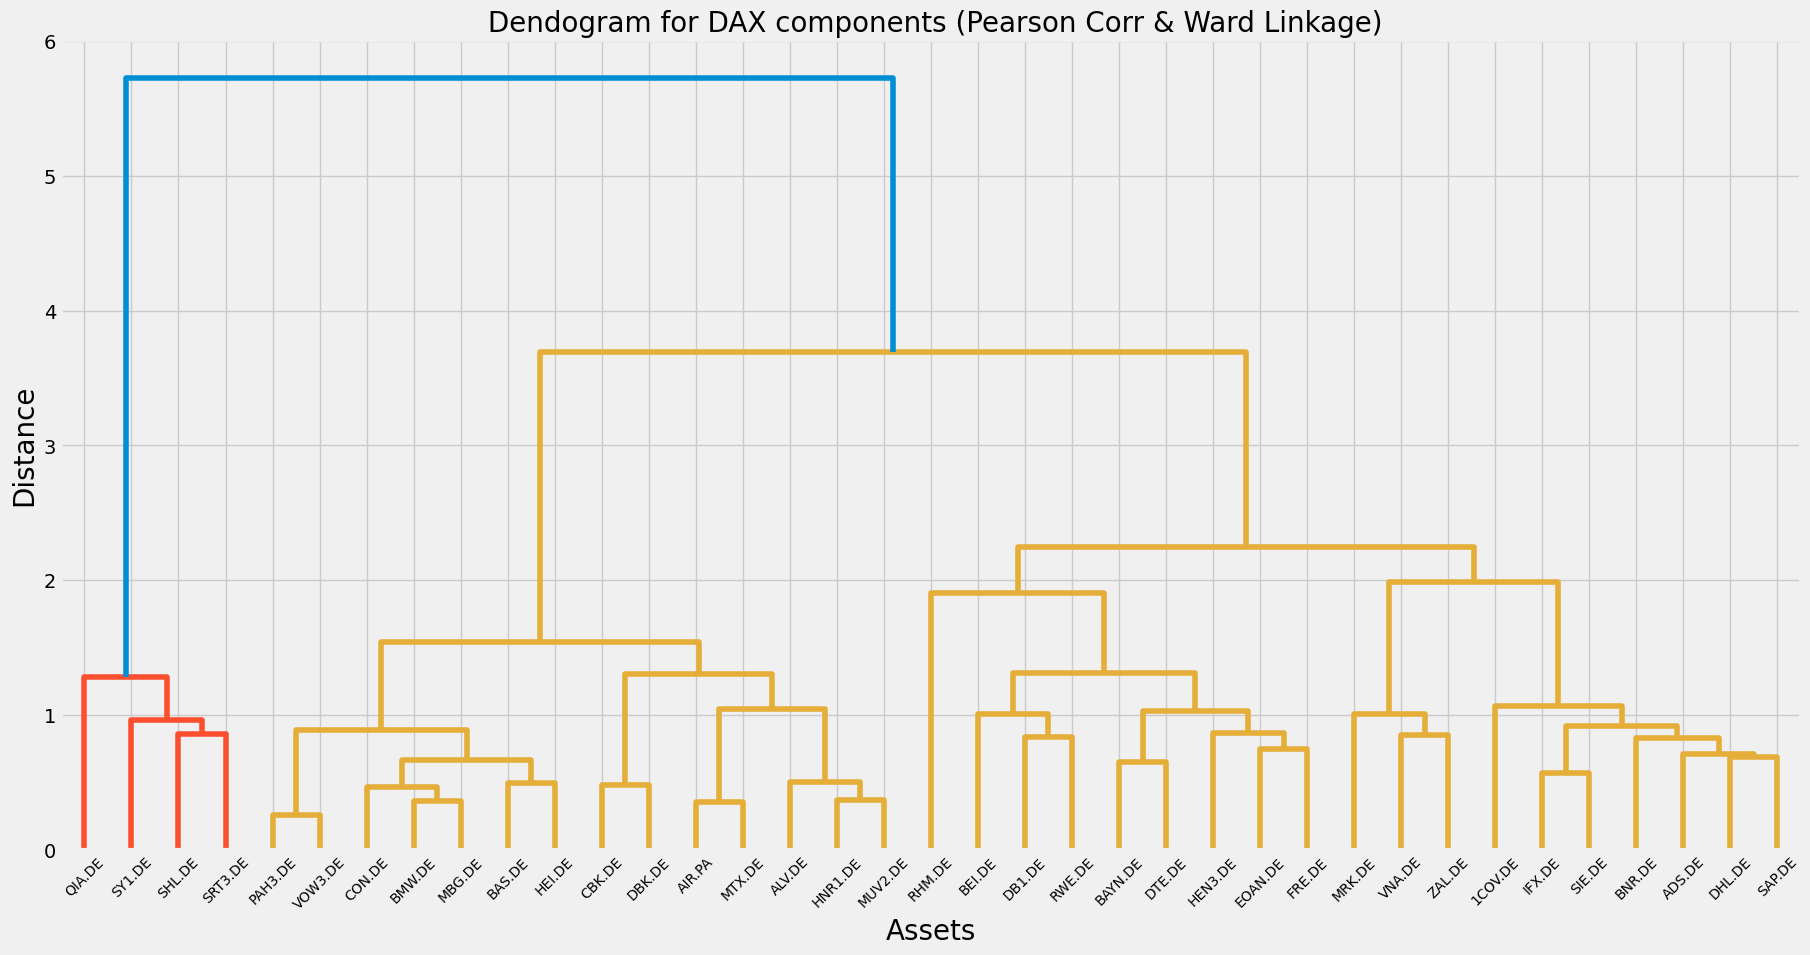

In [199]:
# Hierarchical Clustering Dendogrames
plt.figure(figsize = (20, 10))
labelsize = 20
tciksize = 15
plt.title(' Dendogram for DAX components (Pearson Corr & Ward Linkage)', fontsize = labelsize)
plt.xlabel('Assets', fontsize = labelsize)
plt.ylabel('Distance', fontsize = labelsize)
dendrogram(linkage_de,
           leaf_rotation = 45,   # rotate x axis
           leaf_font_size = 10,  # text font size on x axis
           labels = corr_de.columns)
plt.show()

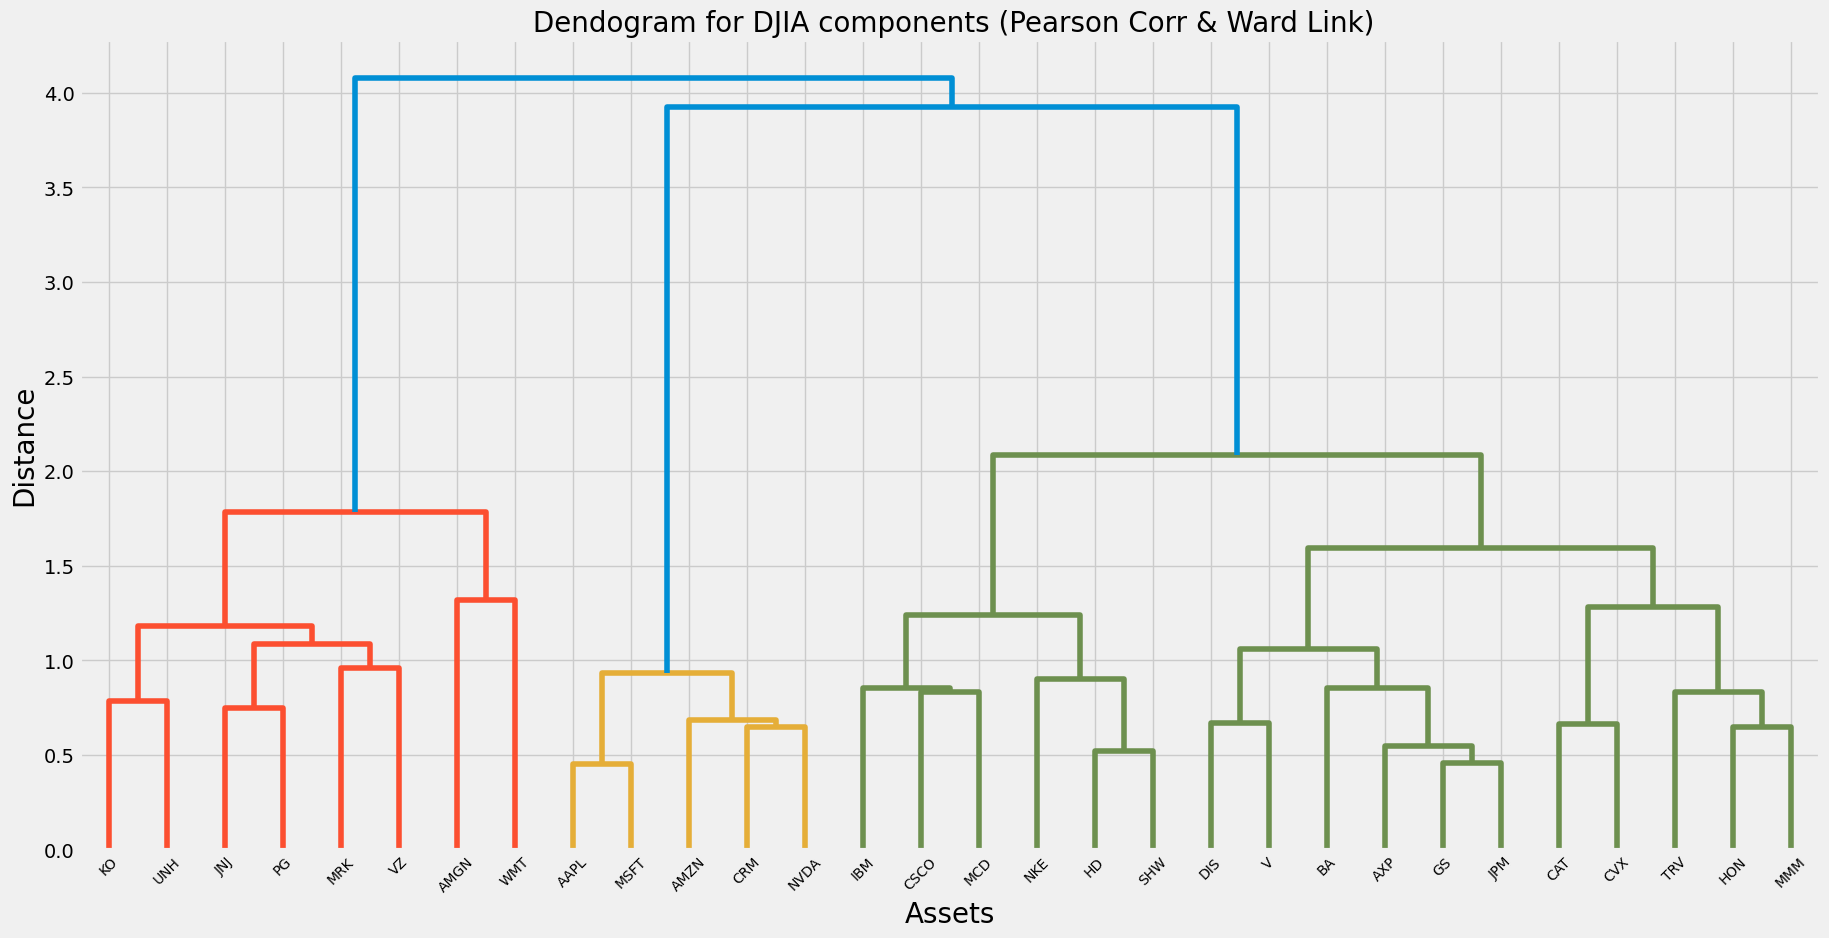

In [200]:
# Hierarchical Clustering Dendogrames
plt.figure(figsize = (20, 10))
labelsize = 20
tciksize = 15
plt.title(' Dendogram for DJIA components (Pearson Corr & Ward Link)', fontsize = labelsize)
plt.xlabel('Assets', fontsize = labelsize)
plt.ylabel('Distance', fontsize = labelsize)
dendrogram(linkage_us,
           leaf_rotation = 45,   # rotate x axis
           leaf_font_size = 10,  # text font size on x axis
           labels = corr_us.columns)
plt.show()

BMW and MBG are most correlated stocks under DAX, while GS and JPM are under DJIA.

In [202]:
#!pip install PyPortfolioOpt

In [203]:
from pypfopt.hierarchical_portfolio import HRPOpt

#wgs = HRPOpt(data_AI_ret)

# Assuming you have already instantiated the HRPOpt class and called the optimize method
hrp_opt = HRPOpt(returns= Returns['DAX-40'])
hrp_opt.optimize()

# Extracting weights
weights = hrp_opt.weights

print(weights * 100)

[1.95921982 1.7763573  1.00338536 1.3823296  1.96965757 3.00239369
 7.49672489 0.9423017  3.60663978 0.92667941 1.09829622 4.86406726
 1.15914727 3.11393127 5.12147153 2.70909832 2.59509231 1.87524477
 4.69373772 1.40539432 1.44606576 1.05915797 4.75216078 1.19678017
 1.94535894 0.56928567 5.98399332 2.57835047 1.95323605 3.57905794
 4.18009948 2.41847879 2.51458404 6.01211045 4.43060144 1.27769226
 1.40181636]


In [204]:
# Function to compute  hierarchical risk parity HRP optimum weights

def HRP_w(rets_df: pd.DataFrame, linkage_method: str = 'ward') -> pd.DataFrame:
  ''' Input: returns df, linkage method.
  output:  Hierarchical Risk Parity weights
  '''
  hrp_opt = HRPOpt(returns= rets_df, cov_matrix = None)
  # construct a HRP using Scipy Hierarchical Clustering: linkage_method = linkage method
  hrp_opt.optimize(linkage_method=  linkage_method)
  #hrp_opt.optimize(linkage_method=linkage_method
  hrp_w = pd.DataFrame(hrp_opt.weights, index = rets_df.columns)
  return hrp_w

<Axes: xlabel='Ticker'>

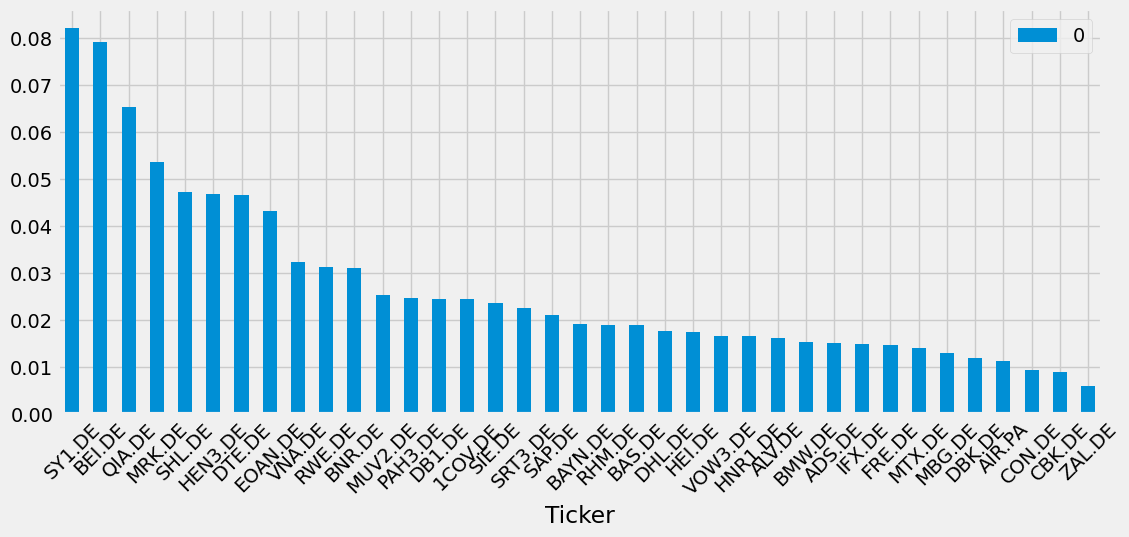

In [243]:
#HRP
W  =   {key: HRP_w(returns) for key, returns in Returns.items()}
W_de = W['DAX-40']
W_de.column = 'DAX-40 Weights'


W_us = W['DJIA-30']
W_us.column = ['Ticker', 'DJIA-30 Weights']

W_de.sort_values(ascending= False,  by=W_de.columns[0]).plot.bar(rot=45, figsize=(12, 5))

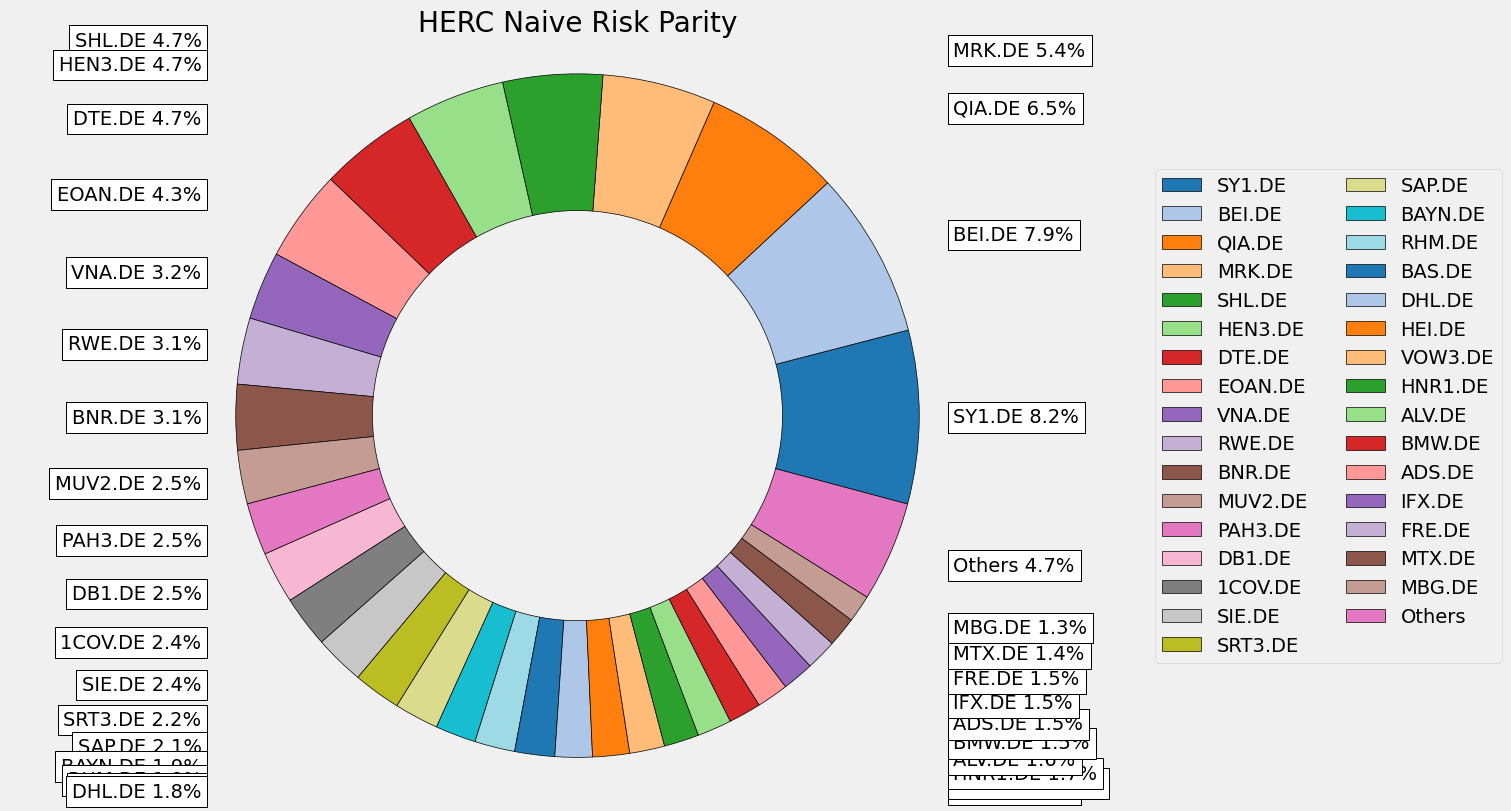

In [265]:
import riskfolio as rp

# DAX
ax = rp.plot_pie(w=  W_de,
                 title='HERC Naive Risk Parity',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=15,
                 ax=None)

<Axes: xlabel='Ticker'>

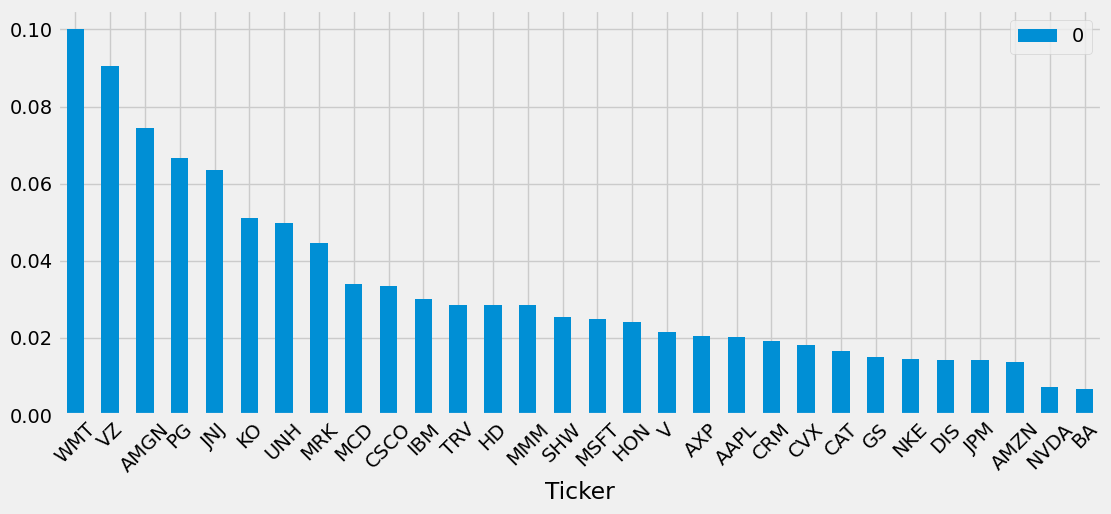

In [244]:
W_us.sort_values(ascending= False,  by=W_us.columns[0]).plot.bar(rot=45, figsize=(12, 5))

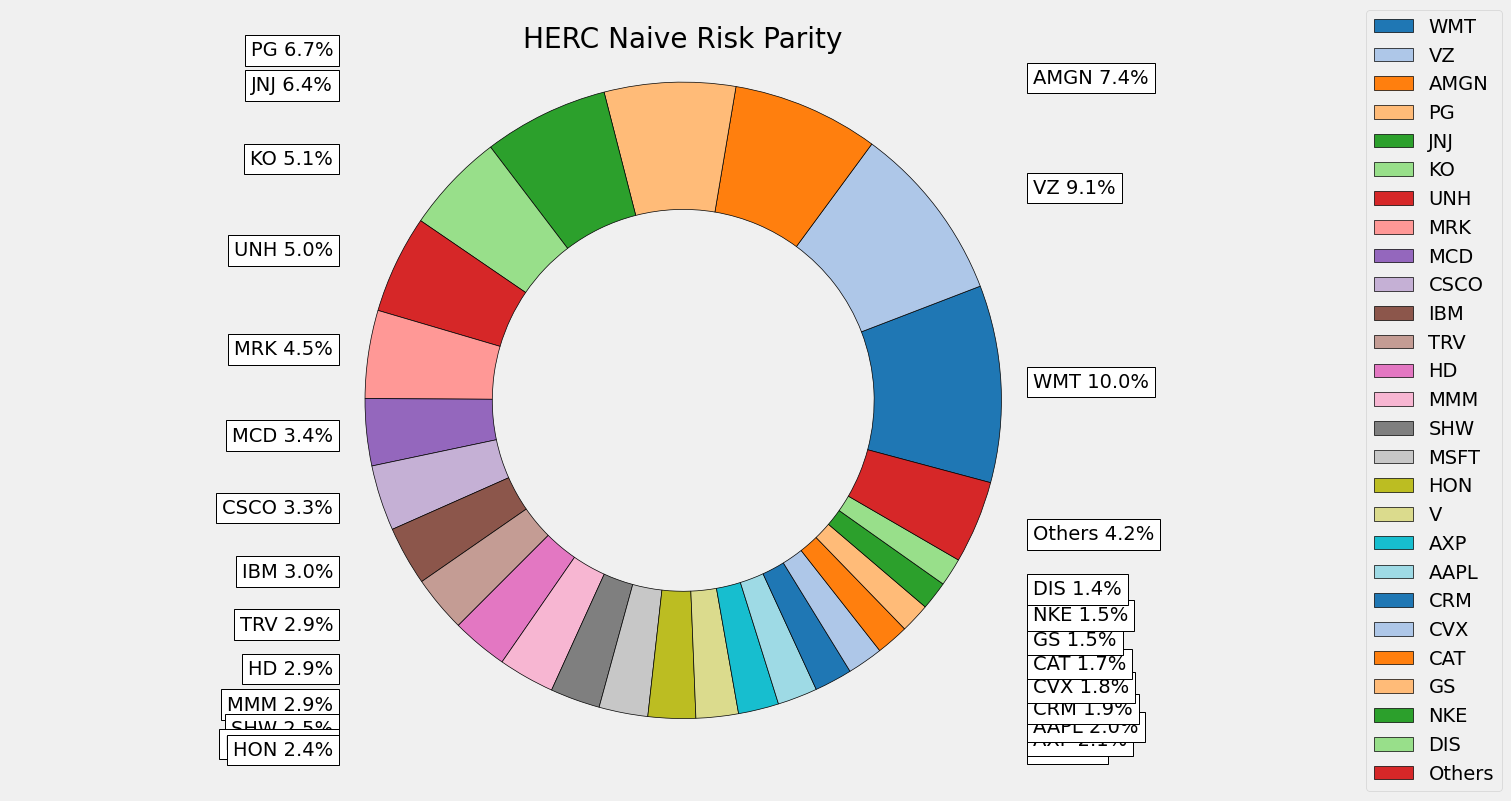

In [266]:
# DJIA
ax = rp.plot_pie(w=  W_us,
                 title='HERC Naive Risk Parity',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=15,
                 ax=None)

In [236]:
#help(pd.DataFrame)

In [262]:
#!pip install riskfolio-lib

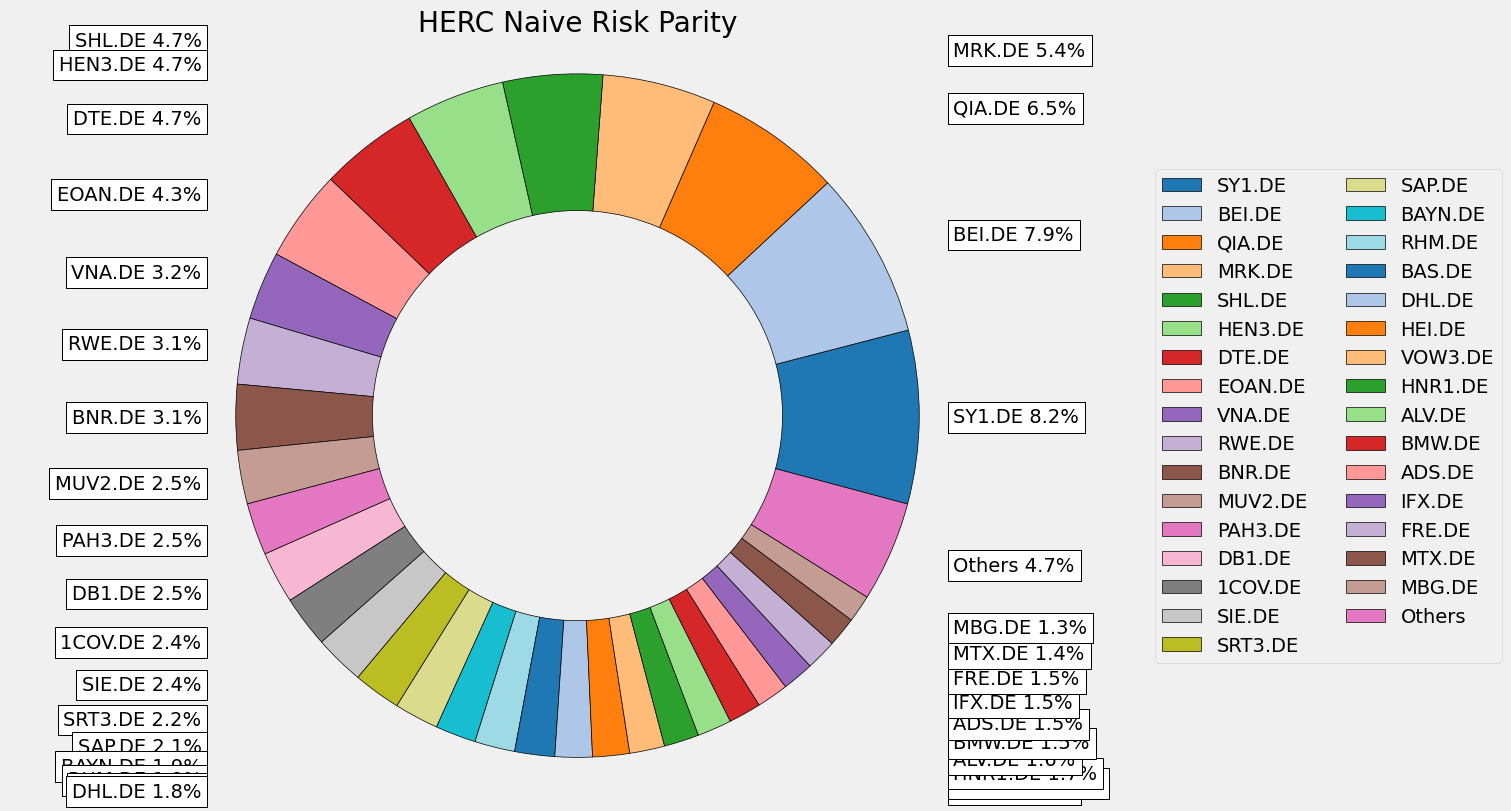

In [264]:
# Plotting the composition of the portfolio
from pypfopt import plotting


In [245]:
# In-sample returns
hrp_returns_de_is = (Returns['DAX-40'] @ W_de)
hrp_returns_us_is = (Returns['DJIA-30'] @ W_us)

In [256]:
## DAX and DJIA - In-sample with HRP
# Concat while ignoring indices
DaxDjia_returns = pd.concat([hrp_returns_de_is.reset_index(drop=True),
                         hrp_returns_us_is.reset_index(drop=True)], axis=1)
DaxDjia_returns.columns = ['DAX-40', 'DJIA-30']
DaxDjia_returns.index = hrp_returns_de_is.index
results = DaxDjia_returns.apply(perf_metrics)
results

results.index = ['Annz. Ret', 'Annz. Vol', 'Sharpe Ratio', 'Annz. G.Ret',   'Down_Vol', 'MaxDrawD', 'VaR_5%', 'CVaR_5%']
results.style.format(precision=2).background_gradient(cmap = 'summer', axis=1)

,DAX-40,DJIA-30
Annz. Ret,11.22,10.41
Annz. Vol,20.00,14.63
Sharpe Ratio,0.56,0.71
Annz. G.Ret,48.04,43.92
Down_Vol,18.46,11.70
MaxDrawD,-28.87,-20.50
VaR_5%,-3.55,-3.27
CVaR_5%,-6.82,-4.67


In [257]:
# Outsample returns
hrp_returns_de_os = (Returns_test['DAX-40'] @ W_de)
hrp_returns_us_os = (Returns_test['DJIA-30'] @ W_us)

In [260]:
## DAX and DJIA - Out-sample with HRP
# Concat while ignoring indices
DaxDjia_returns = pd.concat([hrp_returns_de_os.reset_index(drop=True),
                         hrp_returns_us_os.reset_index(drop=True)], axis=1)
DaxDjia_returns.columns = ['DAX-40', 'DJIA-30']
DaxDjia_returns.index = hrp_returns_de_os.index
results = DaxDjia_returns.apply(perf_metrics)

results.index = ['Annz. Ret', 'Annz. Vol', 'Sharpe Ratio', 'Annz. G.Ret',   'Down_Vol', 'MaxDrawD', 'VaR_5%', 'CVaR_5%']
results.style.format(precision=2).background_gradient(cmap = 'summer', axis=1)

,DAX-40,DJIA-30
Annz. Ret,11.59,24.44
Annz. Vol,11.58,9.97
Sharpe Ratio,1.00,2.45
Annz. G.Ret,17.65,40.82
Down_Vol,6.43,4.89
MaxDrawD,-9.05,-5.33
VaR_5%,-2.42,-1.79
CVaR_5%,-2.72,-2.25


- Results are self explanatory

In [ ]:
# The End!!

# References

- López de Prado, M. (2016). Building Diversified Portfolios that Outperform Out of Sample. The Journal of Portfolio Management, 42(4), 59-69.

- López de Prado, M. (2018). $\textit{Advances in Financial Machine Learning}$. John Wiley & Sons.

